# OULAD Student Performance Prediction

## Problem Definition and Objectives
We aim to predict whether a student will pass or fail a course using early, non?leaking signals. The objective is to build models that support early warning and student support interventions.


## Project Requirements and Rubric Alignment

**Problem Definition & Objectives**
- Predict whether a student will pass or fail using early, non?leaking signals.
- Support early?warning interventions and academic support planning.

**Data Understanding & Preprocessing**
- Dataset description: OULAD tables (studentInfo, studentVle, studentAssessment, assessments, courses, studentRegistration).
- Handling missing values, noise, and outliers is explicitly documented in cleaning/preprocessing.
- Feature engineering covers engagement, activity composition, registration, and assessment?presence indicators.
- All preprocessing steps are justified for stability and early?warning use cases.

**Algorithm Selection & Modeling**
- Baselines: Logistic Regression (interpretable) and Decision Tree (rule?based).
- Complex models: H2O AutoML for broad search; XGBoost for optimized boosting performance.
- Models are trained and evaluated consistently on the same split.

**Evaluation & Results Analysis**
- Metrics: Accuracy, Precision, Recall, F1, AUC, LogLoss.
- Interpretation addresses strengths, limitations, and early?warning suitability.

**Report Quality & Presentation**
- Clear structure, visuals, and conclusions with actionable insights.

**Bonus**
- Multiple algorithms compared.
- Real world, large scale dataset (OULAD).
- Practical recommendations for early?warning interventions.


## Input: Setup and Configuration
All imports and environment initialization (including H2O) are defined here.


In [1]:
# --- Setup and configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

import h2o
from h2o.automl import H2OAutoML
import optuna
import xgboost as xgb

pd.set_option('display.max_columns', 200)
np.random.seed(42)

# Runtime config
TEST_MODE = False  # set True for quick test
AUTOML_MAX_MODELS = 20
AUTOML_MAX_RUNTIME_SECS = 5400  # 1.5 hours
XGB_TRIALS = 10
XGB_EARLY_STOPPING_ROUNDS = 50

if TEST_MODE:
    AUTOML_MAX_MODELS = 1
    AUTOML_MAX_RUNTIME_SECS = 300
    XGB_TRIALS = 1

os.makedirs('h2o_logs', exist_ok=True)

# Initialize H2O
h2o.init(max_mem_size='6G', log_dir='./h2o_logs', log_level='INFO', nthreads=-1)


Checking whether there is an H2O instance running at http://localhost:54321.

c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


.... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from C:\Users\ento3\anaconda3\envs\NLP\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ento3\AppData\Local\Temp\tmp2qwo8my7
  JVM stdout: C:\Users\ento3\AppData\Local\Temp\tmp2qwo8my7\h2o_ento_started_from_python.out
  JVM stderr: C:\Users\ento3\AppData\Local\Temp\tmp2qwo8my7\h2o_ento_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Asia/Bangkok
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 22 days
H2O_cluster_name:,H2O_from_python_ento_90m7lx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.326 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


## Data Loading
We load the OULAD tables and confirm their shape before cleaning.


In [2]:
# CHANGE THIS to your local folder containing the 7 OULAD CSV files
DEFAULT_DATA_DIR = os.path.join('.', 'data')

required_files = [
    'assessments.csv','courses.csv','studentAssessment.csv','studentInfo.csv',
    'studentRegistration.csv','studentVle.csv','vle.csv'
]

# Resolve DATA_DIR from common locations
candidate_dirs = [DEFAULT_DATA_DIR, '.']
resolved = None
for d in candidate_dirs:
    if all(os.path.exists(os.path.join(d, f)) for f in required_files):
        resolved = d
        break

if resolved is None:
    missing = [f for f in required_files if not os.path.exists(os.path.join(DEFAULT_DATA_DIR, f))]
    print('Missing files in DEFAULT_DATA_DIR:', missing)
    print('DEFAULT_DATA_DIR currently set to:', os.path.abspath(DEFAULT_DATA_DIR))
    print('Also checked:', os.path.abspath('.'))
else:
    DATA_DIR = resolved
    print('Using DATA_DIR:', os.path.abspath(DATA_DIR))


Using DATA_DIR: c:\Users\ento3\Downloads\dbm-project-main\dbm-project-main


In [3]:
def read_csv(name, usecols=None, dtype=None):
    path = os.path.join(DATA_DIR, name)
    return pd.read_csv(path, usecols=usecols, dtype=dtype, low_memory=False)
def preview_df(name, df, n=5):
    print(f"\nPreview: {name}")
    print('shape:', df.shape)
    print(df.head(n))

# Read small/medium tables fully
assessments = read_csv('assessments.csv')
courses = read_csv('courses.csv')
student_info = read_csv('studentInfo.csv')
student_reg = read_csv('studentRegistration.csv')
student_assess = read_csv('studentAssessment.csv')
vle = read_csv('vle.csv')

# Read the large clickstream table with only needed columns + smaller dtypes
student_vle = read_csv(
    'studentVle.csv',
    usecols=['code_module','code_presentation','id_student','id_site','date','sum_click'],
    dtype={
        'code_module':'category','code_presentation':'category',
        'id_student':'int32','id_site':'int32',
        'date':'int16','sum_click':'int32'
    }
)

# Quick overview (rows, cols)
overview = pd.DataFrame({
    'table': ['assessments','courses','studentInfo','studentRegistration','studentAssessment','vle','studentVle'],
    'rows': [len(assessments),len(courses),len(student_info),len(student_reg),len(student_assess),len(vle),len(student_vle)],
    'cols': [assessments.shape[1],courses.shape[1],student_info.shape[1],student_reg.shape[1],student_assess.shape[1],vle.shape[1],student_vle.shape[1]]
})
overview


,table,rows,cols
0,assessments,206,6
1,courses,22,3
2,studentInfo,32593,12
3,studentRegistration,32593,5
4,studentAssessment,173912,5
5,vle,6364,6
6,studentVle,10655280,6


## Data Cleaning
We clean raw tables (types, invalid values, deduplication). **No leakage drop occurs here**; all features are retained.


In [4]:
# --- 3.1 assessments: drop known invalid IDs (common in OULAD copies)
# If IDs are missing in your version, this line is harmless.
invalid_ids = {40087, 40088}
assessments = assessments[~assessments['id_assessment'].isin(invalid_ids)].copy()

# Ensure numeric types where needed
assessments['weight'] = pd.to_numeric(assessments['weight'], errors='coerce')
assessments['date'] = pd.to_numeric(assessments['date'], errors='coerce')

# --- 3.2 studentAssessment: clean score/date
student_assess['score'] = student_assess['score'].replace(['?', '', ' '], np.nan)
student_assess['score'] = pd.to_numeric(student_assess['score'], errors='coerce')
student_assess['date_submitted'] = pd.to_numeric(student_assess['date_submitted'], errors='coerce')
student_assess['is_banked'] = pd.to_numeric(student_assess['is_banked'], errors='coerce').fillna(0).astype(int)

before = len(student_assess)
student_assess = student_assess.dropna(subset=['score']).copy()
print('Dropped rows with missing/non-numeric score:', before - len(student_assess))

# --- 3.3 studentInfo: clean imd_band and normalize age label
student_info['imd_band'] = student_info['imd_band'].replace('?', np.nan)
student_info['age_band'] = student_info['age_band'].replace({'55<=': '>=55'})

# --- 3.4 studentVle: drop duplicates to avoid inflated click counts
before = len(student_vle)
student_vle = student_vle.drop_duplicates().copy()
print('Dropped duplicate rows in studentVle:', before - len(student_vle))

# Sanity
print('studentVle rows after dedup:', len(student_vle))


Dropped rows with missing/non-numeric score: 173
Dropped duplicate rows in studentVle: 787170
studentVle rows after dedup: 9868110


## Feature Engineering (Full Feature Space)
We construct the target and build engagement, assessment, and registration aggregates. All features are retained for EDA.


In [5]:
# --- 4.1 Create target (binary) from final_result
student_info['final_result_upd'] = student_info['final_result'].replace({
    'Distinction': 'Pass',
    'Withdrawn': 'Fail'
})
student_info = student_info[student_info['final_result_upd'].isin(['Pass','Fail'])].copy()
student_info['final_result_upd_numeric'] = (student_info['final_result_upd'] == 'Pass').astype(int)

# --- 4.2 VLE features (aggregate to student-module-presentation grain)
# total clicks + active days
vle_agg = (
    student_vle
    .groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
    .agg(
        total_sum_click=('sum_click','sum'),
        active_days=('date','nunique'),
        distinct_sites=('id_site','nunique')
    )
)

# early engagement (<= 14 days)
early = student_vle[student_vle['date'] <= 14]
early_agg = (
    early.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
         .agg(early_sum_click=('sum_click','sum'), early_active_days=('date','nunique'))
)

vle_features = vle_agg.merge(early_agg, on=['id_student','code_module','code_presentation'], how='left')
vle_features[['early_sum_click','early_active_days']] = vle_features[['early_sum_click','early_active_days']].fillna(0)

vle_features['early_click_ratio'] = vle_features['early_sum_click'] / vle_features['total_sum_click'].replace(0, np.nan)
vle_features['early_click_ratio'] = vle_features['early_click_ratio'].fillna(0)

# per-day intensity
vle_features['clicks_per_active_day'] = vle_features['total_sum_click'] / vle_features['active_days'].replace(0, np.nan)
vle_features['clicks_per_active_day'] = vle_features['clicks_per_active_day'].fillna(0)

vle_features['early_clicks_per_active_day'] = vle_features['early_sum_click'] / vle_features['early_active_days'].replace(0, np.nan)
vle_features['early_clicks_per_active_day'] = vle_features['early_clicks_per_active_day'].fillna(0)

vle_features['early_active_ratio'] = vle_features['early_active_days'] / vle_features['active_days'].replace(0, np.nan)
vle_features['early_active_ratio'] = vle_features['early_active_ratio'].fillna(0)

# activity type aggregates
vle_types = student_vle.merge(vle[['id_site','activity_type']], on='id_site', how='left')

vle_type_agg = (
    vle_types.groupby(['id_student','code_module','code_presentation','activity_type'], observed=True)
             .agg(type_clicks=('sum_click','sum'))
             .reset_index()
)

vle_type_pivot = vle_type_agg.pivot_table(
    index=['id_student','code_module','code_presentation'],
    columns='activity_type',
    values='type_clicks',
    fill_value=0
).reset_index()

# Rename columns for clarity
for col in vle_type_pivot.columns:
    if col not in ['id_student','code_module','code_presentation']:
        vle_type_pivot = vle_type_pivot.rename(columns={col: f'clicks_type_{col}'})

# Merge activity type features into main VLE feature set
vle_features = vle_features.merge(vle_type_pivot, on=['id_student','code_module','code_presentation'], how='left')

# Count of activity types used
type_cols = [c for c in vle_features.columns if c.startswith('clicks_type_')]
vle_features['distinct_activity_types'] = (vle_features[type_cols] > 0).sum(axis=1)
# activity type distribution features
type_cols = [c for c in vle_features.columns if c.startswith('clicks_type_')]
type_sum = vle_features[type_cols].sum(axis=1).replace(0, np.nan)
type_probs = vle_features[type_cols].div(type_sum, axis=0).fillna(0)
vle_features['activity_entropy'] = -(type_probs * np.log(type_probs + 1e-9)).sum(axis=1)
vle_features['top_type_share'] = type_probs.max(axis=1)

# log transforms to reduce skew
vle_features['log1p_total_sum_click'] = np.log1p(vle_features['total_sum_click'])
vle_features['log1p_early_sum_click'] = np.log1p(vle_features['early_sum_click'])

# Transparency: check target transformation
preview_df('student_info (target)', student_info)

# Transparency: VLE aggregates
preview_df('vle_agg', vle_agg)
preview_df('early_agg', early_agg)
preview_df('vle_features', vle_features)


C:\Users\ento3\AppData\Local\Temp\ipykernel_24392\2128201024.py:53: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  vle_type_pivot = vle_type_agg.pivot_table(



Preview: student_info (target)
shape: (32593, 14)
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     >=55                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result final_result_upd  \
0              240  

In [6]:
# --- 4.3 Assessment features: weighted score and overall grade
# Join studentAssessment with assessments metadata
sa = student_assess.merge(
    assessments[['id_assessment','code_module','code_presentation','assessment_type','weight','date']],
    on='id_assessment', how='left'
)

# Weighted score rule: if is_banked==1 -> 0 else score * weight
sa['weighted_score'] = np.where(sa['is_banked'] == 1, 0, sa['score'] * (sa['weight'] / 100.0))

# Lateness (optional feature)
sa['lateness_days'] = sa['date_submitted'] - sa['date']

assess_agg = (
    sa.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
      .agg(
          exam_weighted=('weighted_score', lambda x: x[sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          non_exam_weighted=('weighted_score', lambda x: x[~sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          mean_score=('score','mean'),
          late_submissions=('lateness_days', lambda s: (s>0).sum())
      )
)

# overall_grade rule: average if both exist, else use the one available
assess_agg['has_exam'] = (assess_agg['exam_weighted'] > 0).astype(int)
assess_agg['has_non_exam'] = (assess_agg['non_exam_weighted'] > 0).astype(int)
assess_agg['overall_grade'] = np.where(
    (assess_agg['has_exam']==1) & (assess_agg['has_non_exam']==1),
    (assess_agg['exam_weighted'] + assess_agg['non_exam_weighted']) / 2.0,
    np.where(assess_agg['has_exam']==1, assess_agg['exam_weighted'], assess_agg['non_exam_weighted'])
)

# Transparency: assessment aggregates
preview_df('assess_agg', assess_agg)



Preview: assess_agg
shape: (25820, 10)
   id_student code_module code_presentation  exam_weighted  non_exam_weighted  \
0        6516         AAA             2014J            0.0              63.50   
1        8462         DDD             2013J            0.0              34.90   
2        8462         DDD             2014J            0.0               0.00   
3       11391         AAA             2013J            0.0              82.40   
4       23629         BBB             2013B            0.0              16.69   

   mean_score  late_submissions  has_exam  has_non_exam  overall_grade  
0   61.800000                 0         0             1          63.50  
1   87.666667                 1         0             1          34.90  
2   86.500000                 0         0             0           0.00  
3   82.000000                 0         0             1          82.40  
4   82.500000                 3         0             1          16.69  


In [7]:
# --- 4.4 Registration features
student_reg['date_registration'] = pd.to_numeric(student_reg['date_registration'], errors='coerce')
student_reg['date_unregistration'] = pd.to_numeric(student_reg['date_unregistration'], errors='coerce')

reg_features = student_reg[['id_student','code_module','code_presentation','date_registration','date_unregistration']].copy()
reg_features['unregistered_flag'] = reg_features['date_unregistration'].notna().astype(int)

# Transparency: registration features
preview_df('reg_features', reg_features)



Preview: reg_features
shape: (32593, 6)
   id_student code_module code_presentation  date_registration  \
0       11391         AAA             2013J             -159.0   
1       28400         AAA             2013J              -53.0   
2       30268         AAA             2013J              -92.0   
3       31604         AAA             2013J              -52.0   
4       32885         AAA             2013J             -176.0   

   date_unregistration  unregistered_flag  
0                  NaN                  0  
1                  NaN                  0  
2                 12.0                  1  
3                  NaN                  0  
4                  NaN                  0  


In [8]:
# --- Build final dataset at student-module-presentation grain
final_data = (
    student_info
      .merge(vle_features, on=['id_student','code_module','code_presentation'], how='left')
      .merge(assess_agg, on=['id_student','code_module','code_presentation'], how='left')
      .merge(reg_features, on=['id_student','code_module','code_presentation'], how='left')
      .merge(courses, on=['code_module','code_presentation'], how='left')
)

# Derived registration and engagement ratios
if 'date_registration' in final_data.columns:
    final_data['registered_early_flag'] = (final_data['date_registration'] < 0).astype(int)
    final_data['registration_lead_days'] = (-final_data['date_registration']).clip(lower=0)

if 'date_unregistration' in final_data.columns:
    final_data['unregistered_flag'] = final_data['date_unregistration'].notna().astype(int)

if 'module_presentation_length' in final_data.columns:
    final_data['active_days_ratio'] = final_data['active_days'] / final_data['module_presentation_length'].replace(0, np.nan)
    final_data['active_days_ratio'] = final_data['active_days_ratio'].fillna(0)

print('Final dataset shape:', final_data.shape)

# Transparency: final dataset preview
preview_df('final_data', final_data)


Final dataset shape: (32593, 62)

Preview: final_data
shape: (32593, 62)
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     >=55                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result final_result_upd  

## Exploratory Data Analysis (Early-Warning Focus)
Purpose: build a coherent data story for predicting **Fail (0)** vs **Pass (1)** using deployable signals.

### A) Dataset Overview and Target Definition
Purpose: confirm data scope, class labels, and class balance before interpreting feature patterns.

                 table     rows  cols
0          assessments      204     6
1              courses       22     3
2          studentInfo    32593    14
3  studentRegistration    32593     5
4    studentAssessment   173739     5
5                  vle     6364     6
6           studentVle  9868110     6
7           final_data    32593    62
          count   pct
Fail (0)  17208  52.8
Pass (1)  15385  47.2


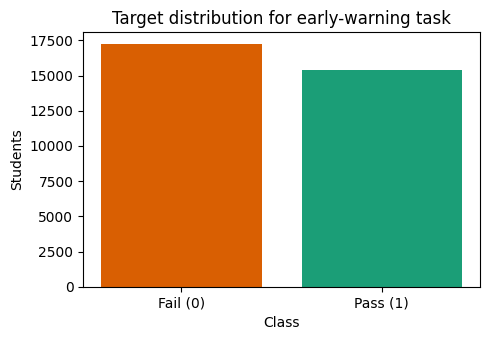

Target definition: Fail (0) is the risk class for intervention; Pass (1) is the success class.


In [9]:
# --- A) Dataset overview and target definition
assert 'final_data' in globals(), "final_data is required for EDA."

_display = globals().get('display', print)

TARGET_EDA = None
if 'final_result_upd_numeric' in final_data.columns:
    TARGET_EDA = 'final_result_upd_numeric'
elif 'TARGET' in globals() and TARGET in final_data.columns:
    TARGET_EDA = TARGET

if TARGET_EDA is None:
    raise ValueError("Target column not found in final_data.")

table_specs = [
    ('assessments', 'assessments'),
    ('courses', 'courses'),
    ('studentInfo', 'student_info'),
    ('studentRegistration', 'student_reg'),
    ('studentAssessment', 'student_assess'),
    ('vle', 'vle'),
    ('studentVle', 'student_vle'),
    ('final_data', 'final_data')
]

overview_rows = []
for table_name, var_name in table_specs:
    if var_name in globals():
        obj = globals()[var_name]
        if hasattr(obj, 'shape'):
            overview_rows.append({
                'table': table_name,
                'rows': int(obj.shape[0]),
                'cols': int(obj.shape[1])
            })

overview = pd.DataFrame(overview_rows)
_display(overview)

target_counts = final_data[TARGET_EDA].value_counts(dropna=False).sort_index()
target_pct = (target_counts / target_counts.sum() * 100).round(2)

target_summary = pd.DataFrame({
    'count': target_counts.astype(int),
    'pct': target_pct
})
target_summary.index = [{0: 'Fail (0)', 1: 'Pass (1)'}.get(v, str(v)) for v in target_summary.index]
_display(target_summary)

plt.figure(figsize=(5, 3.5))
plt.bar(target_summary.index.astype(str), target_summary['count'].values, color=['#d95f02', '#1b9e77'])
plt.title('Target distribution for early-warning task')
plt.xlabel('Class')
plt.ylabel('Students')
plt.tight_layout()
plt.show()

print("Target definition: Fail (0) is the risk class for intervention; Pass (1) is the success class.")

In [10]:
# --- A) Signal availability snapshot in final_data
required_signals = [
    'early_sum_click', 'early_active_days', 'early_click_ratio', 'early_clicks_per_active_day', 'early_active_ratio',
    'total_sum_click', 'active_days', 'clicks_per_active_day',
    'distinct_activity_types', 'activity_entropy', 'top_type_share',
    'registration_lead_days', 'module_presentation_length',
    'overall_grade', 'weighted_score'
]

rows = []
for col in required_signals:
    if col in final_data.columns:
        rows.append({
            'feature': col,
            'dtype': str(final_data[col].dtype),
            'missing_pct': round(float(final_data[col].isna().mean() * 100), 2),
            'n_unique': int(final_data[col].nunique(dropna=True))
        })

availability_df = pd.DataFrame(rows)
if availability_df.empty:
    print("No expected early-warning signal columns were found.")
else:
    _display(availability_df.sort_values(['missing_pct', 'feature'], ascending=[False, True]).reset_index(drop=True))
    print("Purpose: verify which engineered engagement and context signals are available for EDA.")

                        feature    dtype  missing_pct  n_unique
0                 overall_grade  float64        20.78     10126
1                   active_days  float64        10.32       283
2              activity_entropy  float64        10.32     28280
3         clicks_per_active_day  float64        10.32     18455
4       distinct_activity_types  float64        10.32        15
5             early_active_days  float64        10.32        41
6            early_active_ratio  float64        10.32      2838
7             early_click_ratio  float64        10.32     22294
8   early_clicks_per_active_day  float64        10.32      5753
9               early_sum_click  float64        10.32      1429
10               top_type_share  float64        10.32     21877
11              total_sum_click  float64        10.32      5252
12       registration_lead_days  float64         0.14       295
13   module_presentation_length    int64         0.00         7
Purpose: verify which engineered engagem

                   feature  missing_pct  zero_pct_among_non_missing  \
0            overall_grade        20.78                       10.27   
1          early_sum_click        10.32                        3.92   
2        early_active_days        10.32                        3.92   
3        early_click_ratio        10.32                        3.92   
4              active_days        10.32                        0.00   
5          total_sum_click        10.32                        0.00   
6    clicks_per_active_day        10.32                        0.00   
7  distinct_activity_types        10.32                        0.00   
8         activity_entropy        10.32                        0.00   
9           top_type_share        10.32                        0.00   

   coverage_pct  
0         79.22  
1         89.68  
2         89.68  
3         89.68  
4         89.68  
5         89.68  
6         89.68  
7         89.68  
8         89.68  
9         89.68  


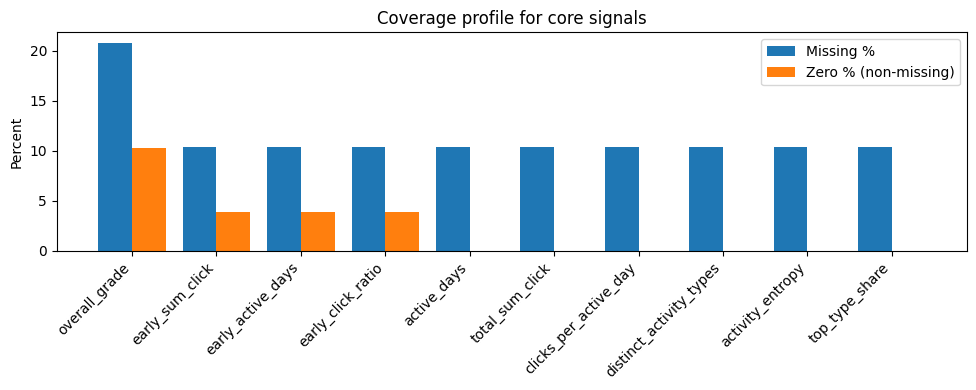

Interpretation: for engagement signals, a true zero activity value is informative and different from missing data.


In [11]:
# --- B) Missingness and coverage analysis (important: missing != 0 for VLE-like signals)
coverage_features = [
    'early_sum_click', 'early_active_days', 'early_click_ratio',
    'total_sum_click', 'active_days', 'clicks_per_active_day',
    'distinct_activity_types', 'activity_entropy', 'top_type_share',
    'overall_grade', 'weighted_score'
]

coverage_rows = []
for col in coverage_features:
    if col not in final_data.columns:
        continue
    s = pd.to_numeric(final_data[col], errors='coerce')
    non_missing_mask = s.notna()
    zero_pct = float((s[non_missing_mask] == 0).mean() * 100) if non_missing_mask.any() else np.nan
    coverage_rows.append({
        'feature': col,
        'missing_pct': round(float((~non_missing_mask).mean() * 100), 2),
        'zero_pct_among_non_missing': round(zero_pct, 2),
        'coverage_pct': round(float(non_missing_mask.mean() * 100), 2)
    })

coverage_df = pd.DataFrame(coverage_rows)
if coverage_df.empty:
    print("Coverage analysis skipped: no candidate columns were found.")
else:
    coverage_df = coverage_df.sort_values('missing_pct', ascending=False).reset_index(drop=True)
    _display(coverage_df)

    plot_df = coverage_df.head(10).copy()
    x = np.arange(len(plot_df))
    w = 0.4

    plt.figure(figsize=(10, 4))
    plt.bar(x - w / 2, plot_df['missing_pct'], width=w, label='Missing %')
    plt.bar(x + w / 2, plot_df['zero_pct_among_non_missing'], width=w, label='Zero % (non-missing)')
    plt.xticks(x, plot_df['feature'], rotation=45, ha='right')
    plt.ylabel('Percent')
    plt.title('Coverage profile for core signals')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Interpretation: for engagement signals, a true zero activity value is informative and different from missing data.")

C:\Users\ento3\AppData\Local\Temp\ipykernel_24392\3383962867.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([fail_vals, pass_vals], labels=['Fail (0)', 'Pass (1)'])
C:\Users\ento3\AppData\Local\Temp\ipykernel_24392\3383962867.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([fail_vals, pass_vals], labels=['Fail (0)', 'Pass (1)'])
C:\Users\ento3\AppData\Local\Temp\ipykernel_24392\3383962867.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([fail_vals, pass_vals], labels=['Fail (0)', 'Pass (1)'])


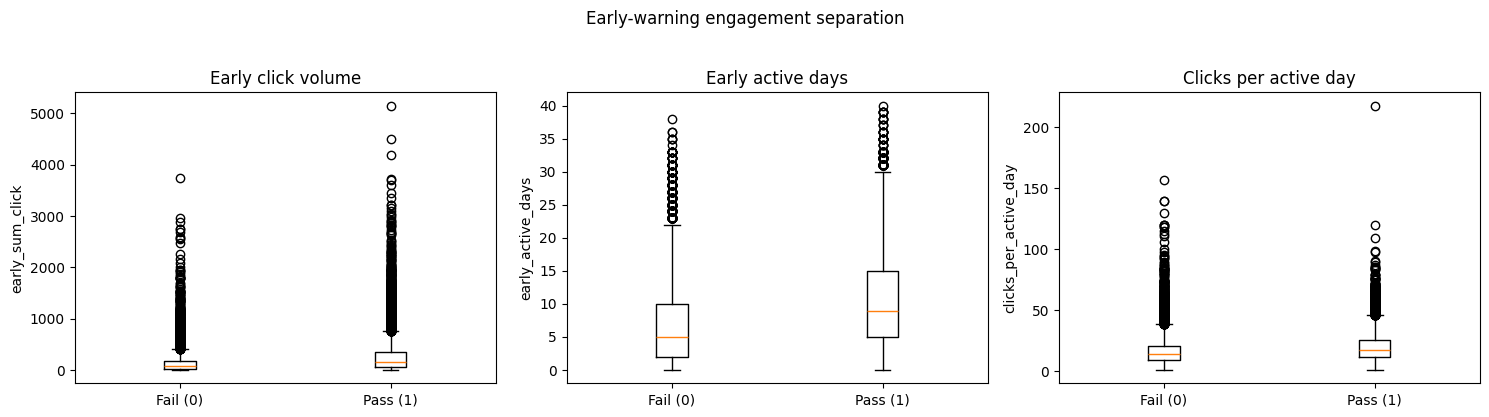

Median early_click_ratio - Fail (0): 0.310, Pass (1): 0.120
Median early_active_ratio - Fail (0): 0.297, Pass (1): 0.114
Note: a lower early_active_ratio for Pass (1) can occur when Pass students stay active for more total days.


In [12]:
# --- C) Core early-warning signals: intensity and timing
core_plot_features = [
    ('early_sum_click', 'Early click volume'),
    ('early_active_days', 'Early active days'),
    ('clicks_per_active_day', 'Clicks per active day')
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (col, title) in zip(axes, core_plot_features):
    if col not in final_data.columns:
        ax.axis('off')
        ax.set_title(f"Missing: {col}")
        continue

    values = pd.to_numeric(final_data[col], errors='coerce')
    fail_vals = values[final_data[TARGET_EDA] == 0].dropna()
    pass_vals = values[final_data[TARGET_EDA] == 1].dropna()

    if fail_vals.empty or pass_vals.empty:
        ax.axis('off')
        ax.set_title(f"Insufficient data: {col}")
        continue

    ax.boxplot([fail_vals, pass_vals], labels=['Fail (0)', 'Pass (1)'])
    ax.set_title(title)
    ax.set_ylabel(col)

plt.suptitle('Early-warning engagement separation', y=1.03)
plt.tight_layout()
plt.show()

if 'early_click_ratio' in final_data.columns:
    tmp_ratio = pd.to_numeric(final_data['early_click_ratio'], errors='coerce')
    med_fail = float(tmp_ratio[final_data[TARGET_EDA] == 0].median())
    med_pass = float(tmp_ratio[final_data[TARGET_EDA] == 1].median())
    print(f"Median early_click_ratio - Fail (0): {med_fail:.3f}, Pass (1): {med_pass:.3f}")

if 'early_active_ratio' in final_data.columns:
    ratio = pd.to_numeric(final_data['early_active_ratio'], errors='coerce')
elif all(c in final_data.columns for c in ['early_active_days', 'active_days']):
    denom = pd.to_numeric(final_data['active_days'], errors='coerce').replace(0, np.nan)
    ratio = pd.to_numeric(final_data['early_active_days'], errors='coerce') / denom
else:
    ratio = None

if ratio is not None:
    med_fail_r = float(ratio[final_data[TARGET_EDA] == 0].median())
    med_pass_r = float(ratio[final_data[TARGET_EDA] == 1].median())
    print(f"Median early_active_ratio - Fail (0): {med_fail_r:.3f}, Pass (1): {med_pass_r:.3f}")
    if med_pass_r < med_fail_r:
        print("Note: a lower early_active_ratio for Pass (1) can occur when Pass students stay active for more total days.")

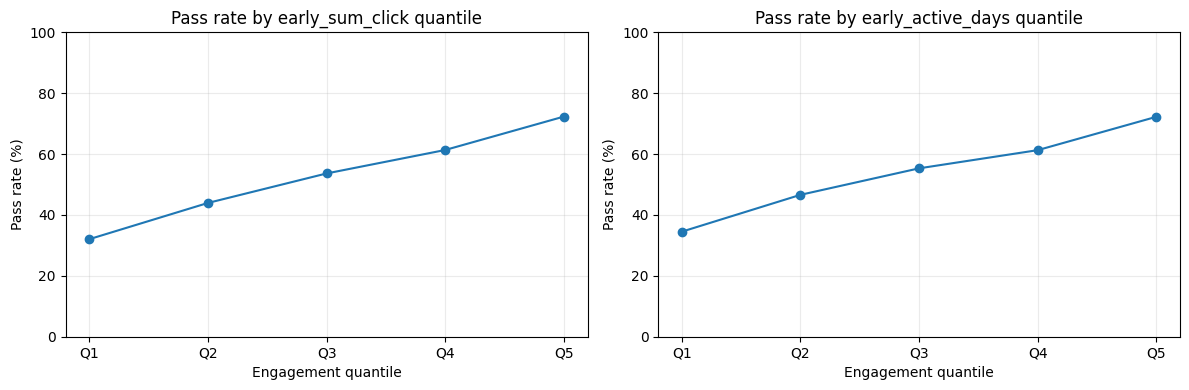

             feature bin  pass_rate_pct     n
0    early_sum_click  Q1      32.052801  5909
1    early_sum_click  Q2      43.953006  5788
2    early_sum_click  Q3      53.637295  5856
3    early_sum_click  Q4      61.344538  5831
4    early_sum_click  Q5      72.313484  5844
5  early_active_days  Q1      34.517279  7292
6  early_active_days  Q2      46.615646  5880
7  early_active_days  Q3      55.321413  4698
8  early_active_days  Q4      61.290842  6213
9  early_active_days  Q5      72.244898  5145
Interpretation: monotonic increase in pass rate across quantiles supports actionable risk ranking.


In [13]:
# --- D) Dose-response analysis: engagement quantiles -> pass rate
dose_features = ['early_sum_click', 'early_active_days']
available_dose = [c for c in dose_features if c in final_data.columns]

if not available_dose:
    print("Dose-response skipped: required columns are missing.")
else:
    fig, axes = plt.subplots(1, len(available_dose), figsize=(6 * len(available_dose), 4))
    if len(available_dose) == 1:
        axes = [axes]

    dose_tables = []

    for ax, col in zip(axes, available_dose):
        tmp = pd.DataFrame({
            'engagement': pd.to_numeric(final_data[col], errors='coerce'),
            'target': pd.to_numeric(final_data[TARGET_EDA], errors='coerce')
        }).dropna()

        if tmp.empty or tmp['engagement'].nunique() < 4:
            ax.axis('off')
            ax.set_title(f"Low variance: {col}")
            continue

        q = min(5, int(tmp['engagement'].nunique()))
        tmp['quantile'] = pd.qcut(tmp['engagement'], q=q, duplicates='drop')
        grp = tmp.groupby('quantile', observed=True)['target'].agg(pass_rate='mean', n='size').reset_index()
        grp['pass_rate_pct'] = grp['pass_rate'] * 100
        grp['bin'] = [f"Q{i+1}" for i in range(len(grp))]
        grp['feature'] = col
        dose_tables.append(grp[['feature', 'bin', 'pass_rate_pct', 'n']])

        ax.plot(grp['bin'], grp['pass_rate_pct'], marker='o')
        ax.set_ylim(0, 100)
        ax.set_title(f'Pass rate by {col} quantile')
        ax.set_xlabel('Engagement quantile')
        ax.set_ylabel('Pass rate (%)')
        ax.grid(alpha=0.25)

    plt.tight_layout()
    plt.show()

    if dose_tables:
        dose_table = pd.concat(dose_tables, ignore_index=True)
        _display(dose_table)
        print("Interpretation: monotonic increase in pass rate across quantiles supports actionable risk ranking.")

C:\Users\ento3\AppData\Local\Temp\ipykernel_24392\3138944841.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([fail_vals, pass_vals], labels=['Fail (0)', 'Pass (1)'])
C:\Users\ento3\AppData\Local\Temp\ipykernel_24392\3138944841.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([fail_vals, pass_vals], labels=['Fail (0)', 'Pass (1)'])


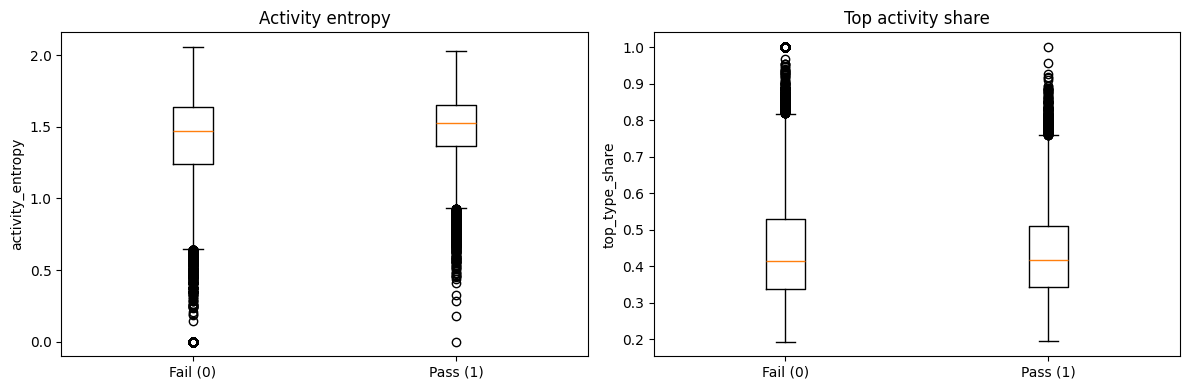

Median distinct_activity_types - Fail (0): 7.00, Pass (1): 9.00
Interpretation: broader and less concentrated activity patterns are typically associated with Pass (1).


In [14]:
# --- E) Activity mix and diversity
mix_features = [
    ('activity_entropy', 'Activity entropy'),
    ('top_type_share', 'Top activity share')
]
available_mix = [item for item in mix_features if item[0] in final_data.columns]

if not available_mix:
    print("Activity mix analysis skipped: required columns are missing.")
else:
    fig, axes = plt.subplots(1, len(available_mix), figsize=(6 * len(available_mix), 4))
    if len(available_mix) == 1:
        axes = [axes]

    for ax, (col, title) in zip(axes, available_mix):
        vals = pd.to_numeric(final_data[col], errors='coerce')
        fail_vals = vals[final_data[TARGET_EDA] == 0].dropna()
        pass_vals = vals[final_data[TARGET_EDA] == 1].dropna()

        if fail_vals.empty or pass_vals.empty:
            ax.axis('off')
            ax.set_title(f"Insufficient data: {col}")
            continue

        ax.boxplot([fail_vals, pass_vals], labels=['Fail (0)', 'Pass (1)'])
        ax.set_title(title)
        ax.set_ylabel(col)

    plt.tight_layout()
    plt.show()

    if 'distinct_activity_types' in final_data.columns:
        dvals = pd.to_numeric(final_data['distinct_activity_types'], errors='coerce')
        med_fail = float(dvals[final_data[TARGET_EDA] == 0].median())
        med_pass = float(dvals[final_data[TARGET_EDA] == 1].median())
        print(f"Median distinct_activity_types - Fail (0): {med_fail:.2f}, Pass (1): {med_pass:.2f}")
    print("Interpretation: broader and less concentrated activity patterns are typically associated with Pass (1).")

### Impact Story
Purpose: turn descriptive EDA into an intervention-oriented narrative for early-warning deployment.

Short interpretation:
- Students with stronger early intensity (click volume and active days) are more likely to pass.
- Dose-response curves show that higher engagement quantiles map to higher pass rates.
- Diversity signals (entropy and concentration) add behavioral context beyond pure volume.

In [15]:
# --- Impact summary table (effect direction for early-warning features)
impact_features = [
    'early_sum_click', 'early_active_days', 'clicks_per_active_day',
    'early_click_ratio', 'activity_entropy', 'top_type_share',
    'distinct_activity_types'
]

impact_rows = []
for col in impact_features:
    if col not in final_data.columns:
        continue
    vals = pd.to_numeric(final_data[col], errors='coerce')
    fail_vals = vals[final_data[TARGET_EDA] == 0].dropna()
    pass_vals = vals[final_data[TARGET_EDA] == 1].dropna()
    if fail_vals.empty or pass_vals.empty:
        continue

    impact_rows.append({
        'feature': col,
        'median_fail_0': float(fail_vals.median()),
        'median_pass_1': float(pass_vals.median()),
        'median_delta_pass_minus_fail': float(pass_vals.median() - fail_vals.median())
    })

impact_summary = pd.DataFrame(impact_rows)
if impact_summary.empty:
    print("Impact summary skipped: no eligible features.")
else:
    impact_summary = impact_summary.sort_values(
        'median_delta_pass_minus_fail',
        key=lambda s: s.abs(),
        ascending=False
    ).reset_index(drop=True)
    _display(impact_summary)

                   feature  median_fail_0  median_pass_1  \
0          early_sum_click      72.000000     165.000000   
1        early_active_days       5.000000       9.000000   
2    clicks_per_active_day      14.000000      17.412304   
3  distinct_activity_types       7.000000       9.000000   
4        early_click_ratio       0.310345       0.120232   
5         activity_entropy       1.470056       1.527906   
6           top_type_share       0.415413       0.417615   

   median_delta_pass_minus_fail  
0                     93.000000  
1                      4.000000  
2                      3.412304  
3                      2.000000  
4                     -0.190113  
5                      0.057850  
6                      0.002202  


     offering     n  pass_rate_pct
0   CCC_2014J  2498      40.632506
1   FFF_2014J  2365      47.230444
2   BBB_2014J  2292      50.261780
3   FFF_2013J  2283      47.963206
4   BBB_2013J  2237      47.921323
5   DDD_2013J  1938      42.776058
6   CCC_2014B  1936      34.245868
7   DDD_2014J  1803      43.926789
8   BBB_2013B  1767      45.444256
9   FFF_2013B  1614      48.451053
10  BBB_2014B  1613      45.071296
11  FFF_2014B  1500      43.600000


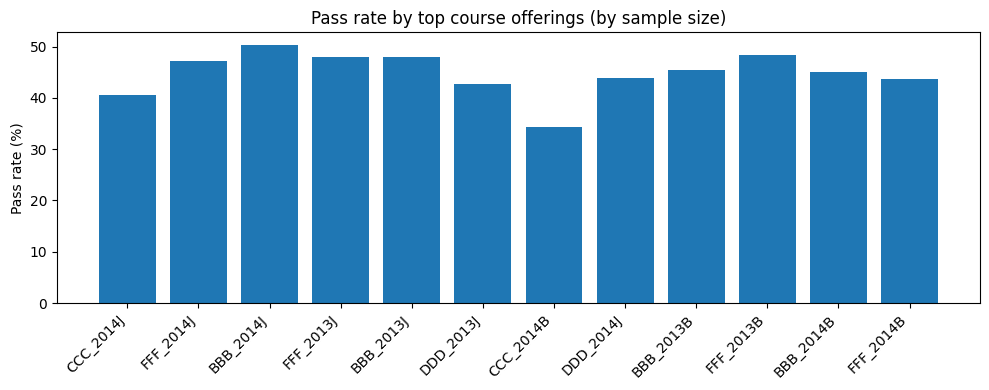

In [16]:
# --- Context check: pass rate by course offering (module + presentation)
if all(c in final_data.columns for c in ['code_module', 'code_presentation', TARGET_EDA]):
    offering = final_data[['code_module', 'code_presentation', TARGET_EDA]].copy()
    offering['offering'] = offering['code_module'].astype(str) + '_' + offering['code_presentation'].astype(str)

    offering_summary = (
        offering.groupby('offering', observed=True)[TARGET_EDA]
        .agg(pass_rate='mean', n='size')
        .sort_values('n', ascending=False)
        .head(12)
        .reset_index()
    )
    offering_summary['pass_rate_pct'] = offering_summary['pass_rate'] * 100
    _display(offering_summary[['offering', 'n', 'pass_rate_pct']])

    plt.figure(figsize=(10, 4))
    plt.bar(offering_summary['offering'], offering_summary['pass_rate_pct'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Pass rate (%)')
    plt.title('Pass rate by top course offerings (by sample size)')
    plt.tight_layout()
    plt.show()
else:
    print("Context check skipped: code_module/code_presentation columns are missing.")

Interpretation:
Offering-level pass rates vary, so later model evaluation includes a group split to test cross-offering generalization.

In [17]:
# --- Coverage by class for key signals (Fail vs Pass)
coverage_cols = ['early_sum_click', 'early_active_days', 'activity_entropy', 'top_type_share', 'overall_grade', 'weighted_score']
rows = []

for col in coverage_cols:
    if col not in final_data.columns:
        continue
    s = pd.to_numeric(final_data[col], errors='coerce')
    for cls, cls_name in [(0, 'Fail (0)'), (1, 'Pass (1)')]:
        cls_mask = final_data[TARGET_EDA] == cls
        if cls_mask.sum() == 0:
            continue
        s_cls = s[cls_mask]
        non_missing = s_cls.notna()
        rows.append({
            'feature': col,
            'class': cls_name,
            'coverage_pct': round(float(non_missing.mean() * 100), 2),
            'zero_pct_among_non_missing': round(float((s_cls[non_missing] == 0).mean() * 100), 2) if non_missing.any() else np.nan
        })

coverage_by_class = pd.DataFrame(rows)
if coverage_by_class.empty:
    print("Class-wise coverage table is empty.")
else:
    _display(coverage_by_class.sort_values(['feature', 'class']).reset_index(drop=True))
    print("This table separates missing values from true zeros for each class.")

             feature     class  coverage_pct  zero_pct_among_non_missing
0   activity_entropy  Fail (0)         80.46                        0.00
1   activity_entropy  Pass (1)         99.98                        0.00
2  early_active_days  Fail (0)         80.46                        5.43
3  early_active_days  Pass (1)         99.98                        2.57
4    early_sum_click  Fail (0)         80.46                        5.43
5    early_sum_click  Pass (1)         99.98                        2.57
6      overall_grade  Fail (0)         60.66                       10.80
7      overall_grade  Pass (1)         99.98                        9.91
8     top_type_share  Fail (0)         80.46                        0.00
9     top_type_share  Pass (1)         99.98                        0.00
This table separates missing values from true zeros for each class.


Interpretation:
Coverage differences by class should be interpreted carefully; low activity can be a real behavioral signal, not just missing data.

In [18]:
# --- Uninformative feature check for EDA reporting
eda_feature_pool = [c for c in FINAL_FEATURES if c in final_data.columns] if 'FINAL_FEATURES' in globals() else list(final_data.columns)
n_unique = final_data[eda_feature_pool].nunique(dropna=True)
constant_features = n_unique[n_unique <= 1].sort_index()

if constant_features.empty:
    print("No constant features detected in the inspected EDA feature pool.")
else:
    const_df = constant_features.reset_index()
    const_df.columns = ['feature', 'n_unique']
    _display(const_df)
    print("Note: these features are kept for pipeline consistency, but they are excluded from interpretation plots.")

No constant features detected in the inspected EDA feature pool.


Interpretation:
Constant or near-constant features are documented for transparency but are not meaningful for EDA conclusions.

In [19]:
# --- Key takeaway table for early-warning EDA
takeaways = []

def _safe_median(col, cls):
    vals = pd.to_numeric(final_data[col], errors='coerce')
    return float(vals[final_data[TARGET_EDA] == cls].median())

for feature, theme in [
    ('early_sum_click', 'Early intensity'),
    ('early_active_days', 'Early consistency'),
    ('clicks_per_active_day', 'Behavioral intensity'),
    ('activity_entropy', 'Activity diversity'),
    ('top_type_share', 'Activity concentration')
]:
    if feature not in final_data.columns:
        continue
    try:
        med_fail = _safe_median(feature, 0)
        med_pass = _safe_median(feature, 1)
    except Exception:
        continue
    direction = 'higher for Pass (1)' if med_pass > med_fail else 'higher for Fail (0)'
    takeaways.append({
        'theme': theme,
        'feature': feature,
        'median_fail_0': round(med_fail, 4),
        'median_pass_1': round(med_pass, 4),
        'direction': direction
    })

takeaways_df = pd.DataFrame(takeaways)
if takeaways_df.empty:
    print("No takeaway rows were generated.")
else:
    _display(takeaways_df)

                    theme                feature  median_fail_0  \
0         Early intensity        early_sum_click        72.0000   
1       Early consistency      early_active_days         5.0000   
2    Behavioral intensity  clicks_per_active_day        14.0000   
3      Activity diversity       activity_entropy         1.4701   
4  Activity concentration         top_type_share         0.4154   

   median_pass_1            direction  
0       165.0000  higher for Pass (1)  
1         9.0000  higher for Pass (1)  
2        17.4123  higher for Pass (1)  
3         1.5279  higher for Pass (1)  
4         0.4176  higher for Pass (1)  


### Transition to Leakage Checks
Purpose: verify whether strong correlations might come from outcome-proximal variables rather than deployable early signals.

In [20]:
# Redundant legacy impact plots were intentionally removed to keep the EDA concise and deployment-focused.
print("Legacy duplicate plots removed.")

Legacy duplicate plots removed.


Note: The refactored EDA keeps only high-signal views aligned with early-warning decisions.

In [21]:
print("Impact story section complete.")

Impact story section complete.


### F) Leakage Risk Inspection
Purpose: detect variables that may encode post-outcome information (for example grade-like features).

In [22]:
# --- Prepare leakage candidate list
if 'TARGET_EDA' not in globals():
    TARGET_EDA = 'final_result_upd_numeric' if 'final_result_upd_numeric' in final_data.columns else TARGET

leakage_keywords = ['score', 'grade', 'assessment', 'exam']
leakage_candidates = [
    c for c in final_data.columns
    if c != TARGET_EDA and any(k in c.lower() for k in leakage_keywords)
]

print("Potential leakage-prone columns found:", leakage_candidates[:20])

Potential leakage-prone columns found: ['exam_weighted', 'non_exam_weighted', 'mean_score', 'has_exam', 'has_non_exam', 'overall_grade']


Interpretation:
Any feature derived from assessment scores close to the final outcome is treated as leakage-prone for strict early-warning deployment.

### Leakage Correlation View
Purpose: rank potential leakage features by correlation with the target and flag them for cautious interpretation.

Leakage-prone candidates ranked by correlation with target:
             feature  corr_with_target  abs_corr
0      overall_grade          0.668809  0.668809
1  non_exam_weighted          0.646707  0.646707
2         mean_score          0.432316  0.432316
3      exam_weighted          0.312875  0.312875
4           has_exam          0.267023  0.267023
5       has_non_exam          0.013167  0.013167


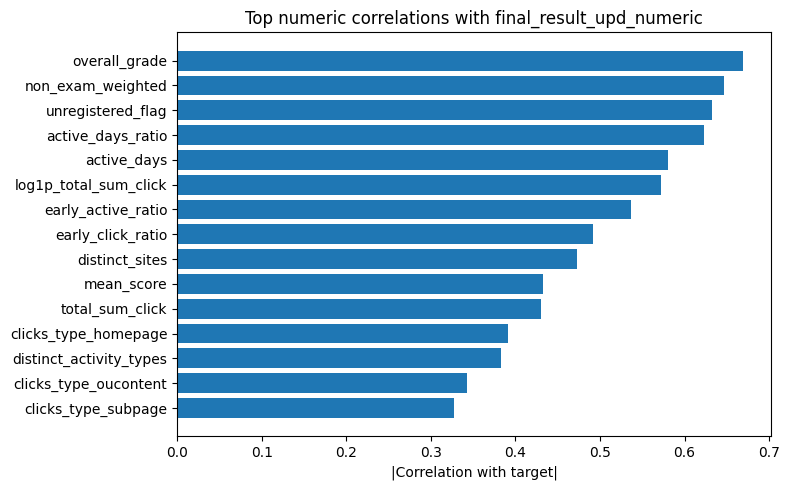

In [23]:
# --- Correlation-based leakage cues (numeric only)
numeric_cols = final_data.select_dtypes(include=['number']).columns.tolist()
if TARGET_EDA not in numeric_cols:
    numeric_cols.append(TARGET_EDA)

corr_source = final_data[[c for c in numeric_cols if c in final_data.columns]].copy()
corr = corr_source.corr(numeric_only=True)

if TARGET_EDA not in corr.columns:
    print("Leakage correlation check skipped: target correlation unavailable.")
else:
    corr_target = corr[TARGET_EDA].drop(labels=[TARGET_EDA], errors='ignore').dropna()
    abs_corr = corr_target.abs().sort_values(ascending=False)

    if 'leakage_candidates' in globals() and leakage_candidates:
        focus_cols = [c for c in abs_corr.index if c in leakage_candidates]
        if focus_cols:
            report = pd.DataFrame({
                'feature': focus_cols,
                'corr_with_target': [corr_target[c] for c in focus_cols],
                'abs_corr': [abs(corr_target[c]) for c in focus_cols]
            }).sort_values('abs_corr', ascending=False)
            print("Leakage-prone candidates ranked by correlation with target:")
            _display(report)
        else:
            print("No keyword-based leakage candidates were found among numeric columns.")

    top_corr = abs_corr.head(15)
    plt.figure(figsize=(8, 5))
    plt.barh(top_corr.index[::-1], top_corr.values[::-1])
    plt.xlabel('|Correlation with target|')
    plt.title('Top numeric correlations with final_result_upd_numeric')
    plt.tight_layout()
    plt.show()

In [24]:
# --- Leakage notes for report writing
risk_rows = []
for col in final_data.columns:
    name = col.lower()
    if col == TARGET_EDA:
        continue
    if any(k in name for k in ['score', 'grade', 'assessment', 'exam_weight']):
        risk = 'high'
        reason = 'Outcome-proximal assessment signal.'
    elif any(k in name for k in ['total_sum_click', 'active_days', 'clicks_type_', 'activity_entropy', 'top_type_share']):
        risk = 'medium'
        reason = 'Behavior signal may include late-course behavior.'
    elif name.startswith('early_') or any(k in name for k in ['registration', 'imd_band', 'age_band', 'highest_education', 'disability']):
        risk = 'low'
        reason = 'Likely available early in the presentation.'
    else:
        continue
    risk_rows.append({'feature': col, 'leakage_risk': risk, 'note': reason})

risk_df = pd.DataFrame(risk_rows).drop_duplicates(subset=['feature']).sort_values(['leakage_risk', 'feature'])
if risk_df.empty:
    print("No leakage notes generated.")
else:
    _display(risk_df.head(30))
    print("Use low/medium/high tags to justify which features are deployable for strict early warning.")

                        feature leakage_risk  \
34                exam_weighted         high   
36                   mean_score         high   
35            non_exam_weighted         high   
37                overall_grade         high   
2                      age_band          low   
38            date_registration          low   
39          date_unregistration          low   
3                    disability          low   
10           early_active_ratio          low   
8             early_click_ratio          low   
9   early_clicks_per_active_day          low   
6               early_sum_click          low   
0             highest_education          low   
1                      imd_band          low   
40       registration_lead_days          low   
5                   active_days       medium   
41            active_days_ratio       medium   
31             activity_entropy       medium   
11         clicks_type_dataplus       medium   
12         clicks_type_dualpane       me

## Feature Drop + Preprocess
Based on EDA and leakage checks, we keep the agreed 40 features and remove all others. We apply additional preprocessing (missing value imputation, scaling, and outlier capping for numeric features) to stabilize training.


In [25]:
# --- Apply final 40-feature list (no external CSV)
TARGET = 'final_result_upd_numeric'
FINAL_FEATURES = [
    'highest_education','imd_band','age_band','num_of_prev_attempts','studied_credits','disability',
    'clicks_per_active_day','clicks_type_dataplus','clicks_type_dualpane','clicks_type_externalquiz',
    'clicks_type_folder','clicks_type_forumng','clicks_type_glossary','clicks_type_homepage',
    'clicks_type_htmlactivity','clicks_type_oucollaborate','clicks_type_oucontent',
    'clicks_type_ouelluminate','clicks_type_ouwiki','clicks_type_page','clicks_type_questionnaire',
    'clicks_type_quiz','clicks_type_repeatactivity','clicks_type_resource','clicks_type_sharedsubpage',
    'clicks_type_subpage','clicks_type_url','distinct_activity_types','activity_entropy','top_type_share',
    'registered_early_flag','registration_lead_days',

    # Added safe engagement signals
    'total_sum_click','active_days','distinct_sites','early_sum_click','early_active_days',
    'early_click_ratio','early_clicks_per_active_day','early_active_ratio',
    'log1p_total_sum_click','log1p_early_sum_click',

    # Added context/structure signals
    'module_presentation_length','date_registration','has_exam','has_non_exam'
]

missing = [f for f in FINAL_FEATURES if f not in final_data.columns]
if missing:
    print('Missing features (not found in dataset):', missing)

FINAL_FEATURES = [f for f in FINAL_FEATURES if f in final_data.columns]

model_data = final_data[FINAL_FEATURES + [TARGET]].copy()

# Outlier capping on numeric features (1st/99th percentile)
num_cols = model_data[FINAL_FEATURES].select_dtypes(include=['number']).columns.tolist()
for c in num_cols:
    low, high = model_data[c].quantile([0.01, 0.99])
    model_data[c] = model_data[c].clip(lower=low, upper=high)

X = model_data[FINAL_FEATURES]
y = model_data[TARGET].astype(int)

# Column types for preprocessing
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocessing pipeline
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

preprocess = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', ohe)
    ]), cat_cols)
])


## Algorithm Principles (Brief)

**Logistic Regression**
- Models the log?odds of the target as a linear function of features.
- Interpretable coefficients; good baseline for binary classification.

**Decision Tree**
- Learns hierarchical if?then splits to separate classes.
- Captures nonlinear relationships; easy to interpret but can overfit.

**XGBoost (Gradient Boosting)**
- Sequentially adds trees to correct previous errors.
- Regularization and shrinkage improve generalization; strong performance on tabular data.

**H2O AutoML**
- Automates model training and hyperparameter search across multiple algorithms.
- Provides a strong leaderboard baseline with minimal manual tuning.


## Modeling
We train models in two stages: (1) simple baselines and (2) AutoML + XGBoost.


In [26]:
# Train/test split (shared across all models)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Logistic Regression (Baseline)

Logistic regression models the probability of the positive class using a linear score passed through a sigmoid:

\[ p(y=1\mid x) = \sigma(z) = 
rac{1}{1+e^{-z}}, \quad z = eta_0 + eta^	op x \]

The log?odds (logit) are linear in features:

\[ \log\left(
rac{p}{1-p}
ight) = eta_0 + eta^	op x \]

Training typically minimizes the negative log?likelihood (log loss / cross?entropy):

\[ L_{\log}(y,p) = -(y \log p + (1-y)\log(1-p)) \]

Why it fits this task:
- Interpretable coefficients (direction + magnitude of impact).
- Strong baseline for binary outcomes.
- Works well with mixed numeric + one?hot encoded categorical features.


In [27]:
# --- Logistic Regression
logreg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
logreg_pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', logreg)])
logreg_pipe.fit(X_train, y_train)

logreg_pred = logreg_pipe.predict(X_test)
logreg_prob = logreg_pipe.predict_proba(X_test)[:, 1]

logreg_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, logreg_pred),
    'Precision': precision_score(y_test, logreg_pred),
    'Recall': recall_score(y_test, logreg_pred),
    'F1': f1_score(y_test, logreg_pred),
    'AUC': roc_auc_score(y_test, logreg_prob),
    'LogLoss': log_loss(y_test, logreg_prob)
}

logreg_metrics


{'Model': 'Logistic Regression',
 'Accuracy': 0.8708390857493481,
 'Precision': 0.8674778033541598,
 'Recall': 0.8573285667858304,
 'F1': 0.8623733246158876,
 'AUC': 0.9372092469913702,
 'LogLoss': 0.3261587929762459}

### Decision Tree (Baseline)

Decision trees split data using impurity criteria (Gini or entropy). For a node with class proportions \(p_k\):

**Gini:**  \( H(Q) = \sum_k p_k(1-p_k) \)

**Entropy:**  \( H(Q) = -\sum_k p_k \log(p_k) \)

The algorithm chooses splits that most reduce impurity, producing human?readable rules.

Why it fits this task:
- Captures non?linear relationships.
- Easy to interpret and explain to stakeholders.
- Useful as a transparent baseline.


In [28]:
# --- Decision Tree
clf_tree = DecisionTreeClassifier(max_depth=6, random_state=42)

tree_pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', clf_tree)])
tree_pipe.fit(X_train, y_train)

tree_pred = tree_pipe.predict(X_test)

tree_prob = None
if hasattr(tree_pipe, 'predict_proba'):
    tree_prob = tree_pipe.predict_proba(X_test)[:, 1]


tree_metrics = {
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, tree_pred),
    'Precision': precision_score(y_test, tree_pred),
    'Recall': recall_score(y_test, tree_pred),
    'F1': f1_score(y_test, tree_pred),
    'AUC': roc_auc_score(y_test, tree_prob) if tree_prob is not None else None,
    'LogLoss': log_loss(y_test, tree_prob) if tree_prob is not None else None
}

tree_metrics


{'Model': 'Decision Tree',
 'Accuracy': 0.8732934499156312,
 'Precision': 0.8403386755367402,
 'Recall': 0.9031524211894703,
 'F1': 0.8706140350877193,
 'AUC': 0.9320180635809497,
 'LogLoss': 0.3254451381733806}

### H2O AutoML (Complex Model)

H2O AutoML trains multiple model families (GLM, GBM, DRF, DeepLearning, XRT) and stacked ensembles within a time or model limit. It ranks models on a leaderboard using a chosen metric (AUC here).

Why it fits this task:
- Efficiently explores strong model families without manual tuning.
- Produces an optimized leaderboard and ensemble leader.
- Good for tabular datasets with mixed feature types.


In [29]:
# --- Stage 2A: H2O AutoML
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(test_df)

h2o_train[TARGET] = h2o_train[TARGET].asfactor()
h2o_test[TARGET] = h2o_test[TARGET].asfactor()

aml = H2OAutoML(
    max_models=AUTOML_MAX_MODELS,
    max_runtime_secs=AUTOML_MAX_RUNTIME_SECS,
    seed=42,
    sort_metric='AUC',
    nfolds=5,
    exclude_algos=['XGBoost'],
    verbosity='info'
)

aml.train(x=FINAL_FEATURES, y=TARGET, training_frame=h2o_train, validation_frame=h2o_test)

leader = aml.leader
perf = leader.model_performance(h2o_test)

automl_metrics = {
    'Model': 'H2O AutoML (leader)',
    'Accuracy': perf.accuracy()[0][1] if perf.accuracy() else None,
    'Precision': perf.precision()[0][1] if perf.precision() else None,
    'Recall': perf.recall()[0][1] if perf.recall() else None,
    'F1': perf.F1()[0][1] if perf.F1() else None,
    'AUC': perf.auc(),
    'LogLoss': perf.logloss()
}

automl_metrics


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
02:51:35.756: Project: AutoML_1_20260216_25135
02:51:35.757: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
02:51:35.762: Setting stopping tolerance adaptively based on the training frame: 0.00619292997561756
02:51:35.762: Build control seed: 42
02:51:35.763: training frame: Frame key: AutoML_1_20260216_25135_training_py_1_sid_89a4    cols: 47    rows: 26074  chunks: 2    size: 3392774  checksum: -4290677731826974258
02:51:35.763: validation frame: Frame key: py_2_sid_89a4    cols: 47    rows: 6519  chunks: 1    size: 852389  checksum: -5859195256362500584
02:51:35.763: lea

{'Model': 'H2O AutoML (leader)',
 'Accuracy': 0.9196195735542261,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1': 0.9188271604938271,
 'AUC': 0.9662582520271392,
 'LogLoss': 0.21218247982848884}

### XGBoost + Optuna (Complex Model)

XGBoost is gradient boosting with a regularized objective. It adds trees sequentially to correct errors, while controlling complexity via penalties on tree structure and leaf weights.

A typical objective form is:

\[ \mathrm{Obj} = \sum_i L(y_i, \hat{y}_i) + \sum_k \Omega(f_k), \quad \Omega(f_k)=\gamma T + 
rac{1}{2}\lambda\sum_j w_j^2 \]

We use Optuna to optimize key hyperparameters (depth, learning rate, subsampling, regularization). This balances bias and variance while maximizing AUC.


In [30]:
# --- Stage 2B: XGBoost + Optuna (uses same split)
# Transform features with preprocessing
X_train_t = preprocess.fit_transform(X_train)
X_test_t = preprocess.transform(X_test)

# Build DMatrix
if hasattr(X_train_t, 'toarray'):
    dtrain = xgb.DMatrix(X_train_t, label=y_train)
    dvalid = xgb.DMatrix(X_test_t, label=y_test)
else:
    dtrain = xgb.DMatrix(X_train_t, label=y_train)
    dvalid = xgb.DMatrix(X_test_t, label=y_test)

# Optuna objective

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda:0',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
        verbose_eval=False
    )
    y_pred = model.predict(dvalid)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=XGB_TRIALS, show_progress_bar=True)

best_params = study.best_params
best_auc = study.best_value
print('Best AUC:', best_auc)

final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'device': 'cuda:0',
    **best_params
}

n_estimators = final_params.pop('n_estimators')
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=n_estimators,
    evals=[(dtrain, 'train'), (dvalid, 'validation')],
    early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
    verbose_eval=10
)

y_pred = final_model.predict(dvalid)

xgb_metrics = {
    'Model': 'XGBoost (Optuna best)',
    'Accuracy': accuracy_score(y_test, (y_pred >= 0.5).astype(int)),
    'Precision': precision_score(y_test, (y_pred >= 0.5).astype(int)),
    'Recall': recall_score(y_test, (y_pred >= 0.5).astype(int)),
    'F1': f1_score(y_test, (y_pred >= 0.5).astype(int)),
    'AUC': roc_auc_score(y_test, y_pred),
    'LogLoss': log_loss(y_test, y_pred)
}

xgb_metrics


[I 2026-02-16 03:29:02,871] A new study created in memory with name: no-name-1da3d634-b920-4e87-ba2b-ab36c9a049cd
  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.965424:  10%|█         | 1/10 [00:01<00:11,  1.28s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:04,152] Trial 0 finished with value: 0.9654241502765453 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 613, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 0.9654241502765453.


Best trial: 1. Best value: 0.965691:  20%|██        | 2/10 [00:09<00:43,  5.41s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:12,457] Trial 1 finished with value: 0.9656906020696375 and parameters: {'max_depth': 8, 'learning_rate': 0.010725209743171996, 'n_estimators': 779, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 0.9656906020696375.


Best trial: 2. Best value: 0.96584:  30%|███       | 3/10 [00:13<00:33,  4.72s/it] c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:16,358] Trial 2 finished with value: 0.9658403513764567 and parameters: {'max_depth': 6, 'learning_rate': 0.02692655251486473, 'n_estimators': 528, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 3.925879806965068, 'reg_lambda': 0.9983689107917987}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  40%|████      | 4/10 [00:14<00:19,  3.27s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:17,407] Trial 3 finished with value: 0.9634191524642448 and parameters: {'max_depth': 7, 'learning_rate': 0.07500118950416987, 'n_estimators': 132, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 4.828160165372797, 'reg_lambda': 4.041986740582305}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  50%|█████     | 5/10 [00:18<00:17,  3.44s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:21,139] Trial 4 finished with value: 0.9625587076767009 and parameters: {'max_depth': 5, 'learning_rate': 0.013940346079873234, 'n_estimators': 579, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 4.546602010393911, 'reg_lambda': 1.2938999080000846}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  60%|██████    | 6/10 [00:21<00:13,  3.49s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:24,743] Trial 5 finished with value: 0.964850835149807 and parameters: {'max_depth': 8, 'learning_rate': 0.028869220380495747, 'n_estimators': 464, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 4.697494707820946, 'reg_lambda': 4.474136752138244}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  70%|███████   | 7/10 [00:22<00:07,  2.66s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:25,685] Trial 6 finished with value: 0.9642051946958153 and parameters: {'max_depth': 7, 'learning_rate': 0.22999586428143728, 'n_estimators': 162, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 1.3567451588694794, 'reg_lambda': 4.143687545759647}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  80%|████████  | 8/10 [00:25<00:05,  2.74s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:28,600] Trial 7 finished with value: 0.9633507927554571 and parameters: {'max_depth': 5, 'learning_rate': 0.026000059117302653, 'n_estimators': 480, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 3.861223846483287, 'reg_lambda': 0.993578407670862}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 8. Best value: 0.96589:  90%|█████████ | 9/10 [00:28<00:02,  2.60s/it]c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\xgboost\callback.py:385: UserWarning: [03:29:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-16 03:29:30,903] Trial 8 finished with value: 0.9658898271877893 and parameters: {'max_depth': 3, 'learning_rate': 0.1601531217136121, 'n_estimators': 595, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 0.5793452976256486, 'reg_lambda': 4.315517129377968}. Best is trial 8 with value: 0.9658898271877893.


Best trial: 8. Best value: 0.96589: 100%|██████████| 10/10 [00:29<00:00,  2.94s/it]

[I 2026-02-16 03:29:32,292] Trial 9 finished with value: 0.9606490735465489 and parameters: {'max_depth': 7, 'learning_rate': 0.030816017044468066, 'n_estimators': 144, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 2.3610746258097466}. Best is trial 8 with value: 0.9658898271877893.
Best AUC: 0.9658898271877893
[0]	train-auc:0.89909	validation-auc:0.90263
[10]	train-auc:0.93228	validation-auc:0.93298
[20]	train-auc:0.94090	validation-auc:0.94170
[30]	train-auc:0.94859	validation-auc:0.94879


[40]	train-auc:0.95309	validation-auc:0.95239
[50]	train-auc:0.95567	validation-auc:0.95489
[60]	train-auc:0.95830	validation-auc:0.95708
[70]	train-auc:0.95975	validation-auc:0.95828
[80]	train-auc:0.96145	validation-auc:0.95950
[90]	train-auc:0.96282	validation-auc:0.96028
[100]	train-auc:0.96433	validation-auc:0.96119
[110]	train-auc:0.96514	validation-auc:0.96173
[120]	train-auc:0.96608	validation-auc:0.96207
[130]	train-auc:0.96704	validation-auc:0.96265
[140]	train-auc:0.96777	validation-auc:0.96276
[150]	train-auc:0.96871	validation-auc:0.96311
[160]	train-auc:0.96931	validation-auc:0.96326
[170]	train-auc:0.97004	validation-auc:0.96357
[180]	train-auc:0.97066	validation-auc:0.96361
[190]	train-auc:0.97110	validation-auc:0.96374
[200]	train-auc:0.97166	validation-auc:0.96401
[210]	train-auc:0.97216	validation-auc:0.96424
[220]	train-auc:0.97265	validation-auc:0.96411
[230]	train-auc:0.97314	validation-auc:0.96414
[240]	train-auc:0.97350	validation-auc:0.96431
[250]	train-auc:0.9

{'Model': 'XGBoost (Optuna best)',
 'Accuracy': 0.9190059825126553,
 'Precision': 0.8844645550527903,
 'Recall': 0.9528761780955476,
 'F1': 0.9173967459324155,
 'AUC': 0.9658898271877893,
 'LogLoss': 0.21470856558889903}

## Evaluation and Discussion
We compare models using accuracy, precision, recall, F1, AUC, and log loss, then discuss strengths, limitations, and early?warning relevance.


In [31]:
# --- Consolidated results
all_results = []
all_results.append(logreg_metrics)
all_results.append(tree_metrics)
all_results.append(automl_metrics)
all_results.append(xgb_metrics)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('AUC', ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,AUC,LogLoss
2,H2O AutoML (leader),0.919620,1.000000,1.000000,0.918827,0.966258,0.212182
3,XGBoost (Optuna best),0.919006,0.884465,0.952876,0.917397,0.965890,0.214709
0,Logistic Regression,0.870839,0.867478,0.857329,0.862373,0.937209,0.326159
1,Decision Tree,0.873293,0.840339,0.903152,0.870614,0.932018,0.325445


## Conclusions and Future Improvements

- The simple models provide interpretable baselines.
- AutoML and XGBoost improve predictive performance on the same early?warning feature set.
- Future work: extend temporal validation, incorporate intervention timing, and evaluate fairness across demographic groups.


## Rubric Alignment Summary
- Problem definition and objectives: early warning for pass/fail prediction.
- Dataset description and preprocessing: detailed cleaning, feature engineering, and justification.
- Algorithm selection: baselines + AutoML + XGBoost.
- Evaluation: multiple metrics with discussion.
- Conclusions and future improvements included.


## EDA and Comparison Extensions 


### 1) Feature Dictionary for `FINAL_FEATURES`
Purpose: document dtype, missingness, cardinality, and leakage risk (`low` / `medium` / `high`).

In [32]:
import pandas as pd
import numpy as np

assert 'final_data' in globals(), "final_data not found."
assert 'FINAL_FEATURES' in globals(), "FINAL_FEATURES not found."
assert 'TARGET' in globals(), "TARGET not found."

feature_list = [f for f in FINAL_FEATURES if f in final_data.columns]
if not feature_list:
    raise ValueError("No FINAL_FEATURES columns are present in final_data.")

fd = final_data[feature_list].copy()

def leakage_risk_tag(name):
    n = name.lower()
    if any(k in n for k in ['score', 'grade', 'assessment', 'exam_weight']):
        return 'high'
    if any(k in n for k in ['total_sum_click', 'active_days', 'clicks_type_', 'distinct_activity_types', 'activity_entropy', 'top_type_share', 'clicks_per_active_day', 'distinct_sites', 'log1p_total']):
        return 'medium'
    if n.startswith('early_') or 'log1p_early' in n:
        return 'low'
    if any(k in n for k in ['registration', 'registered_early', 'module_presentation_length', 'date_registration', 'has_exam', 'has_non_exam']):
        return 'low'
    if any(k in n for k in ['age_band', 'imd_band', 'highest_education', 'gender', 'disability', 'studied_credits', 'num_of_prev_attempts']):
        return 'low'
    return 'medium'

dictionary_df = pd.DataFrame({
    'feature': feature_list,
    'dtype': [str(fd[c].dtype) for c in feature_list],
    'missing_pct': [round(float(fd[c].isna().mean() * 100), 2) for c in feature_list],
    'n_unique': [int(fd[c].nunique(dropna=True)) for c in feature_list],
})
dictionary_df['leakage_risk'] = dictionary_df['feature'].map(leakage_risk_tag)
dictionary_df['uninformative'] = np.where(dictionary_df['n_unique'] <= 1, 'yes', 'no')

risk_order = pd.CategoricalDtype(categories=['low', 'medium', 'high'], ordered=True)
dictionary_df['leakage_risk'] = dictionary_df['leakage_risk'].astype(risk_order)
dictionary_df = dictionary_df.sort_values(['leakage_risk', 'missing_pct', 'feature'], ascending=[True, False, True]).reset_index(drop=True)

display(dictionary_df)

const_df = dictionary_df[dictionary_df['uninformative'] == 'yes'][['feature', 'n_unique', 'missing_pct']]
if const_df.empty:
    print("No constant features inside FINAL_FEATURES.")
else:
    print("Constant/uninformative features found (kept in pipeline, excluded from interpretation emphasis):")
    display(const_df)

,feature,dtype,missing_pct,n_unique,leakage_risk,uninformative
0,has_exam,float64,20.78,2,low,no
1,has_non_exam,float64,20.78,2,low,no
2,early_active_ratio,float64,10.32,2838,low,no
3,early_click_ratio,float64,10.32,22294,low,no
4,early_sum_click,float64,10.32,1429,low,no
5,log1p_early_sum_click,float64,10.32,1429,low,no
6,imd_band,object,3.41,10,low,no
7,date_registration,float64,0.14,332,low,no
8,registration_lead_days,float64,0.14,295,low,no
9,age_band,object,0.00,3,low,no


No constant features inside FINAL_FEATURES.


### 2) Baseline vs Best Model: Confusion Matrix and Classification Report
Purpose: compare a baseline model with the strongest available model on the same test split.

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\ento3\anaconda3\envs\NLP\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,model,auc_pass
0,H2O AutoML (leader),0.966255
1,XGBoost (Optuna best),0.965890
2,Logistic Regression (baseline),0.937209
3,Decision Tree,0.932018


Baseline model: Logistic Regression (baseline)
Best model by AUC: H2O AutoML (leader)
Logistic Regression (baseline) @ pass-threshold 0.50
              precision    recall  f1-score   support

    Fail (0)     0.8738    0.8829    0.8783      3442
    Pass (1)     0.8675    0.8573    0.8624      3077

    accuracy                         0.8708      6519
   macro avg     0.8706    0.8701    0.8703      6519
weighted avg     0.8708    0.8708    0.8708      6519



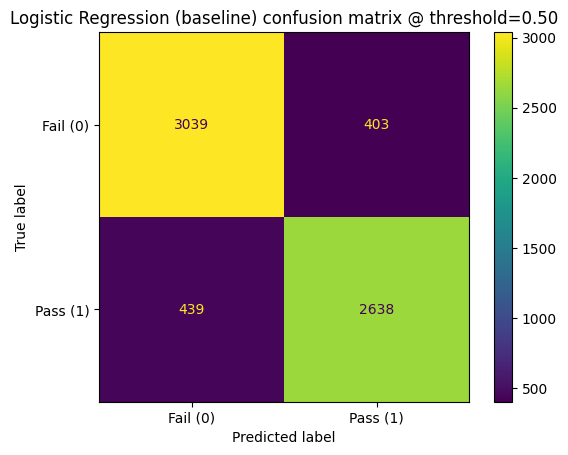

H2O AutoML (leader) @ pass-threshold 0.50
              precision    recall  f1-score   support

    Fail (0)     0.9544    0.8881    0.9201      3442
    Pass (1)     0.8839    0.9526    0.9169      3077

    accuracy                         0.9185      6519
   macro avg     0.9192    0.9203    0.9185      6519
weighted avg     0.9211    0.9185    0.9186      6519



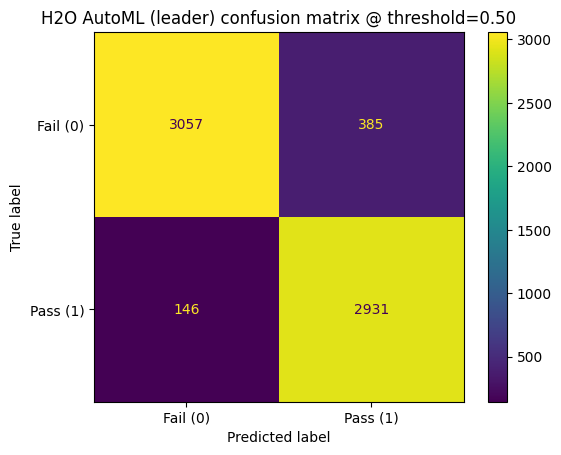

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

assert 'y_test' in globals() and 'X_test' in globals(), "Need X_test and y_test from the modeling split."

y_true_eval = np.asarray(y_test.values if hasattr(y_test, 'values') else y_test).astype(int)

candidate_rows = []
EVAL_CANDIDATES = {}

def _add_candidate(name, proba_pass):
    try:
        arr = np.asarray(proba_pass, dtype=float).reshape(-1)
    except Exception:
        return
    if arr.shape[0] != y_true_eval.shape[0]:
        return
    if np.isnan(arr).any():
        return
    auc_val = roc_auc_score(y_true_eval, arr)
    EVAL_CANDIDATES[name] = arr
    candidate_rows.append({'model': name, 'auc_pass': auc_val})

if 'logreg_pipe' in globals():
    try:
        _add_candidate('Logistic Regression (baseline)', logreg_pipe.predict_proba(X_test)[:, 1])
    except Exception as e:
        print('Logistic Regression scoring skipped:', e)

if 'tree_pipe' in globals() and hasattr(tree_pipe, 'predict_proba'):
    try:
        _add_candidate('Decision Tree', tree_pipe.predict_proba(X_test)[:, 1])
    except Exception as e:
        print('Decision Tree scoring skipped:', e)

if 'final_model' in globals():
    try:
        if 'dvalid' in globals():
            _add_candidate('XGBoost (Optuna best)', final_model.predict(dvalid))
        elif 'preprocess' in globals():
            X_test_t = preprocess.transform(X_test)
            dtmp = xgb.DMatrix(X_test_t, label=y_true_eval)
            _add_candidate('XGBoost (Optuna best)', final_model.predict(dtmp))
    except Exception as e:
        print('XGBoost scoring skipped:', e)

if 'leader' in globals() and 'h2o_test' in globals():
    try:
        pred_h2o = leader.predict(h2o_test).as_data_frame()
        if 'p1' in pred_h2o.columns:
            _add_candidate('H2O AutoML (leader)', pred_h2o['p1'].values)
    except Exception as e:
        print('H2O scoring skipped:', e)

if not candidate_rows:
    raise RuntimeError("No model probabilities were collected. Run model training cells first.")

candidate_df = pd.DataFrame(candidate_rows).sort_values('auc_pass', ascending=False).reset_index(drop=True)
display(candidate_df)

BASELINE_MODEL_NAME = 'Logistic Regression (baseline)' if 'Logistic Regression (baseline)' in EVAL_CANDIDATES else candidate_df.loc[0, 'model']
BEST_MODEL_NAME = candidate_df.loc[0, 'model']
BEST_MODEL_PROBA_PASS = EVAL_CANDIDATES[BEST_MODEL_NAME]

print(f"Baseline model: {BASELINE_MODEL_NAME}")
print(f"Best model by AUC: {BEST_MODEL_NAME}")

def evaluate_pass_threshold(model_name, threshold=0.5):
    proba_pass = EVAL_CANDIDATES[model_name]
    y_pred_pass = (proba_pass >= threshold).astype(int)
    cm = confusion_matrix(y_true_eval, y_pred_pass, labels=[0, 1])

    print("=" * 90)
    print(f"{model_name} @ pass-threshold {threshold:.2f}")
    print(classification_report(
        y_true_eval, y_pred_pass, labels=[0, 1],
        target_names=['Fail (0)', 'Pass (1)'], digits=4, zero_division=0
    ))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail (0)', 'Pass (1)'])
    disp.plot(values_format='d')
    plt.title(f'{model_name} confusion matrix @ threshold={threshold:.2f}')
    plt.show()
    return cm

models_to_show = [BASELINE_MODEL_NAME]
if BEST_MODEL_NAME not in models_to_show:
    models_to_show.append(BEST_MODEL_NAME)

for model_name in models_to_show:
    evaluate_pass_threshold(model_name, threshold=0.5)

### 3) ROC and Precision-Recall Curves
Purpose: compare ranking quality and class-specific retrieval, including `Fail (0)` as the positive class.

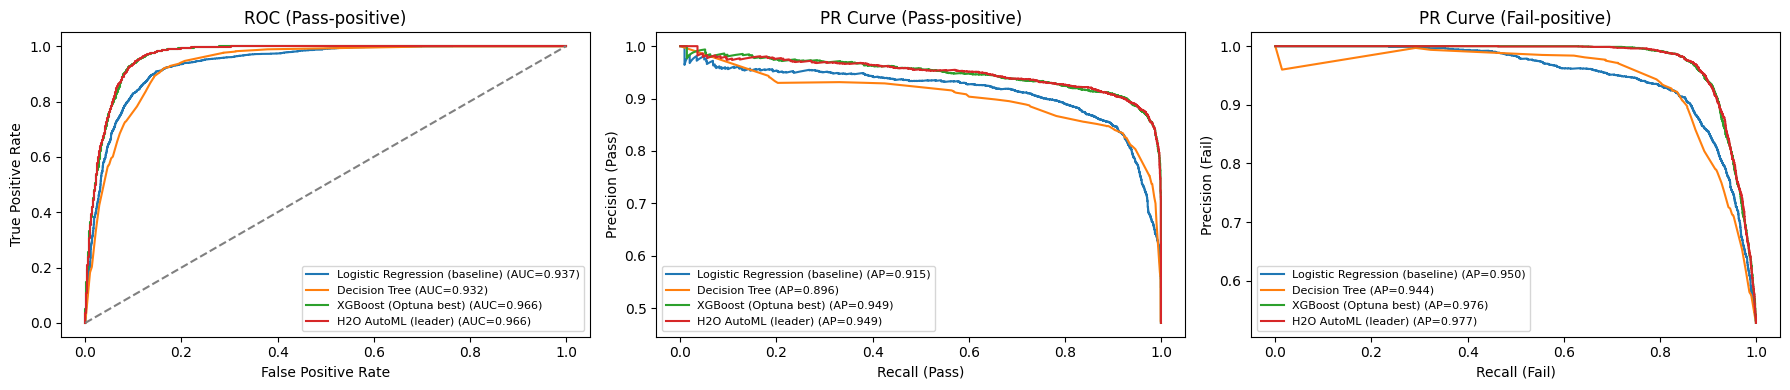

In [34]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

assert 'EVAL_CANDIDATES' in globals() and len(EVAL_CANDIDATES) > 0, "Run the baseline-vs-best evaluation cell first."

y_true_eval = np.asarray(y_test.values if hasattr(y_test, 'values') else y_test).astype(int)
y_fail_true = 1 - y_true_eval

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for model_name, proba_pass in EVAL_CANDIDATES.items():
    proba_pass = np.asarray(proba_pass, dtype=float)
    proba_fail = 1.0 - proba_pass

    fpr, tpr, _ = roc_curve(y_true_eval, proba_pass)
    auc_pass = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC={auc_pass:.3f})')

    prec_pass, rec_pass, _ = precision_recall_curve(y_true_eval, proba_pass)
    ap_pass = average_precision_score(y_true_eval, proba_pass)
    axes[1].plot(rec_pass, prec_pass, label=f'{model_name} (AP={ap_pass:.3f})')

    prec_fail, rec_fail, _ = precision_recall_curve(y_fail_true, proba_fail)
    ap_fail = average_precision_score(y_fail_true, proba_fail)
    axes[2].plot(rec_fail, prec_fail, label=f'{model_name} (AP={ap_fail:.3f})')

axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_title('ROC (Pass-positive)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(fontsize=8)

axes[1].set_title('PR Curve (Pass-positive)')
axes[1].set_xlabel('Recall (Pass)')
axes[1].set_ylabel('Precision (Pass)')
axes[1].legend(fontsize=8)

axes[2].set_title('PR Curve (Fail-positive)')
axes[2].set_xlabel('Recall (Fail)')
axes[2].set_ylabel('Precision (Fail)')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

### 4) Threshold Tuning for Fail Detection
Purpose: choose a threshold that prioritizes identifying `Fail (0)` students (maximize `F1_fail`, with recall constraint when possible).

Tuned model: H2O AutoML (leader)
Selection rule: best F1_fail with recall_fail >= 0.70
Chosen fail-positive threshold: 0.475


,threshold_fail,precision_fail,recall_fail,f1_fail,accuracy,tp_fail_detected,fn_fail_missed,fp_false_alarm,tn_pass_correct
0,0.050,0.618832,0.990994,0.761894,0.672956,3411,31,2101,976
1,0.075,0.666667,0.982568,0.794363,0.731401,3382,60,1691,1386
2,0.100,0.711351,0.975886,0.822881,0.778187,3359,83,1363,1714
3,0.125,0.748206,0.969494,0.844596,0.811628,3337,105,1123,1954
4,0.150,0.775846,0.959326,0.857885,0.832183,3302,140,954,2123
5,0.175,0.802002,0.954387,0.871584,0.851511,3285,157,811,2266
6,0.200,0.826528,0.946833,0.882600,0.867004,3259,183,684,2393
7,0.225,0.846797,0.941023,0.891427,0.878969,3239,203,586,2491
8,0.250,0.866631,0.936374,0.900154,0.890321,3223,219,496,2581
9,0.275,0.881948,0.931145,0.905879,0.897837,3205,237,429,2648


,threshold_fail,precision_fail,recall_fail,f1_fail,accuracy,tp_fail_detected,fn_fail_missed,fp_false_alarm,tn_pass_correct
17,0.475,0.950247,0.893376,0.920934,0.919006,3075.0,367.0,161.0,2916.0


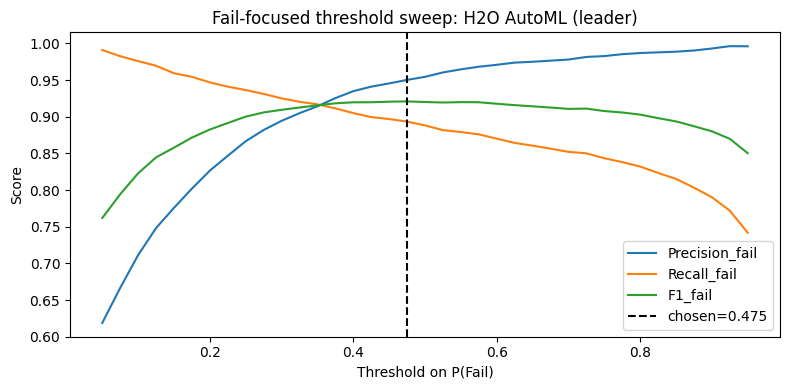

,tp_fail_detected,fn_fail_missed,fp_false_alarm,tn_pass_correct
0,3075,367,161,2916


              precision    recall  f1-score   support

    Fail (0)     0.9502    0.8934    0.9209      3442
    Pass (1)     0.8882    0.9477    0.9170      3077

    accuracy                         0.9190      6519
   macro avg     0.9192    0.9205    0.9190      6519
weighted avg     0.9210    0.9190    0.9191      6519



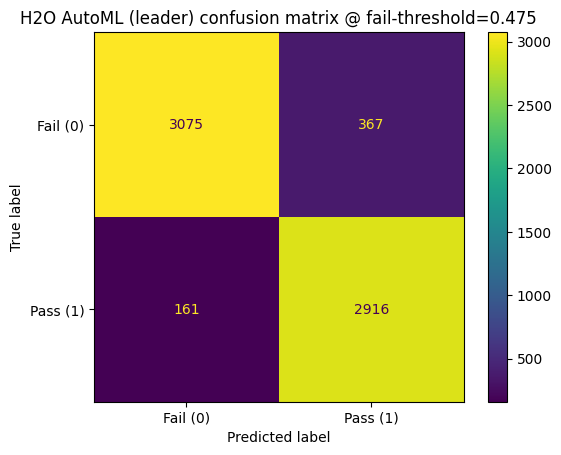

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'BEST_MODEL_NAME' in globals() and 'BEST_MODEL_PROBA_PASS' in globals(), "Run the baseline-vs-best evaluation cell first."

y_true_eval = np.asarray(y_test.values if hasattr(y_test, 'values') else y_test).astype(int)
proba_pass = np.asarray(BEST_MODEL_PROBA_PASS, dtype=float)
proba_fail = 1.0 - proba_pass
y_fail_true = (y_true_eval == 0).astype(int)

target_recall_fail = 0.70
threshold_grid = np.linspace(0.05, 0.95, 37)

rows = []
for thr in threshold_grid:
    pred_fail = (proba_fail >= thr).astype(int)

    tp_fail_detected = int(((y_fail_true == 1) & (pred_fail == 1)).sum())
    fn_fail_missed = int(((y_fail_true == 1) & (pred_fail == 0)).sum())
    fp_false_alarm = int(((y_fail_true == 0) & (pred_fail == 1)).sum())
    tn_pass_correct = int(((y_fail_true == 0) & (pred_fail == 0)).sum())

    precision_fail = tp_fail_detected / (tp_fail_detected + fp_false_alarm) if (tp_fail_detected + fp_false_alarm) > 0 else 0.0
    recall_fail = tp_fail_detected / (tp_fail_detected + fn_fail_missed) if (tp_fail_detected + fn_fail_missed) > 0 else 0.0
    f1_fail = 2 * precision_fail * recall_fail / (precision_fail + recall_fail) if (precision_fail + recall_fail) > 0 else 0.0

    y_pred_pass = 1 - pred_fail
    accuracy = float((y_pred_pass == y_true_eval).mean())

    rows.append({
        'threshold_fail': round(float(thr), 3),
        'precision_fail': precision_fail,
        'recall_fail': recall_fail,
        'f1_fail': f1_fail,
        'accuracy': accuracy,
        'tp_fail_detected': tp_fail_detected,
        'fn_fail_missed': fn_fail_missed,
        'fp_false_alarm': fp_false_alarm,
        'tn_pass_correct': tn_pass_correct
    })

tune_df = pd.DataFrame(rows)

eligible = tune_df[tune_df['recall_fail'] >= target_recall_fail]
if not eligible.empty:
    best_row = eligible.sort_values(['f1_fail', 'precision_fail'], ascending=False).iloc[0]
    selection_reason = f"best F1_fail with recall_fail >= {target_recall_fail:.2f}"
else:
    best_row = tune_df.sort_values(['f1_fail', 'recall_fail'], ascending=False).iloc[0]
    selection_reason = "best F1_fail (no threshold met recall target)"

BEST_FAIL_THRESHOLD = float(best_row['threshold_fail'])

print(f"Tuned model: {BEST_MODEL_NAME}")
print(f"Selection rule: {selection_reason}")
print(f"Chosen fail-positive threshold: {BEST_FAIL_THRESHOLD:.3f}")

display(tune_df)
display(best_row.to_frame().T)

plt.figure(figsize=(8, 4))
plt.plot(tune_df['threshold_fail'], tune_df['precision_fail'], label='Precision_fail')
plt.plot(tune_df['threshold_fail'], tune_df['recall_fail'], label='Recall_fail')
plt.plot(tune_df['threshold_fail'], tune_df['f1_fail'], label='F1_fail')
plt.axvline(BEST_FAIL_THRESHOLD, color='black', linestyle='--', label=f"chosen={BEST_FAIL_THRESHOLD:.3f}")
plt.xlabel('Threshold on P(Fail)')
plt.ylabel('Score')
plt.title(f'Fail-focused threshold sweep: {BEST_MODEL_NAME}')
plt.legend()
plt.tight_layout()
plt.show()

pred_fail_best = (proba_fail >= BEST_FAIL_THRESHOLD).astype(int)
pred_pass_best = 1 - pred_fail_best

component_table = pd.DataFrame([{
    'tp_fail_detected': int(((y_true_eval == 0) & (pred_pass_best == 0)).sum()),
    'fn_fail_missed': int(((y_true_eval == 0) & (pred_pass_best == 1)).sum()),
    'fp_false_alarm': int(((y_true_eval == 1) & (pred_pass_best == 0)).sum()),
    'tn_pass_correct': int(((y_true_eval == 1) & (pred_pass_best == 1)).sum())
}])
display(component_table)

print(classification_report(
    y_true_eval, pred_pass_best, labels=[0, 1],
    target_names=['Fail (0)', 'Pass (1)'], digits=4, zero_division=0
))
cm_best = confusion_matrix(y_true_eval, pred_pass_best, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['Fail (0)', 'Pass (1)'])
disp.plot(values_format='d')
plt.title(f'{BEST_MODEL_NAME} confusion matrix @ fail-threshold={BEST_FAIL_THRESHOLD:.3f}')
plt.show()

### 5) Error Analysis by Context
Purpose: inspect where Fail students are still missed after fail-focused threshold tuning.

In [36]:
import pandas as pd
import numpy as np

assert 'BEST_FAIL_THRESHOLD' in globals(), "Run threshold tuning first."

y_true_eval = np.asarray(y_test.values if hasattr(y_test, 'values') else y_test).astype(int)
proba_pass = np.asarray(BEST_MODEL_PROBA_PASS, dtype=float)
pred_fail = ((1.0 - proba_pass) >= BEST_FAIL_THRESHOLD).astype(int)
pred_pass = 1 - pred_fail

analysis = pd.DataFrame(index=X_test.index)
analysis['y_true'] = y_true_eval
analysis['y_pred'] = pred_pass
analysis['proba_pass'] = proba_pass
analysis['error_type'] = 'Correct'
analysis.loc[(analysis['y_true'] == 0) & (analysis['y_pred'] == 1), 'error_type'] = 'Missed Fail (Fail->Pass)'
analysis.loc[(analysis['y_true'] == 1) & (analysis['y_pred'] == 0), 'error_type'] = 'False Alarm (Pass->Fail)'

display(analysis['error_type'].value_counts().rename_axis('error_type').to_frame('count'))

context_cols = [c for c in ['code_module', 'code_presentation', 'imd_band', 'age_band', 'highest_education', 'region', 'disability', 'gender'] if c in final_data.columns]
if not context_cols:
    print("No context columns available for slicing.")
else:
    context = final_data.loc[analysis.index, context_cols].copy()
    analysis_ctx = pd.concat([analysis, context], axis=1)

    misses = analysis_ctx[analysis_ctx['error_type'] == 'Missed Fail (Fail->Pass)']
    if misses.empty:
        print("No missed Fail cases at the tuned threshold.")
    else:
        print("Top slices for missed Fail cases:")
        for col in context_cols[:4]:
            display(misses[col].value_counts(dropna=False).head(10).rename_axis(col).to_frame('missed_fail_count'))

    if all(c in analysis_ctx.columns for c in ['code_module', 'code_presentation']):
        by_offering = (
            analysis_ctx.assign(offering=analysis_ctx['code_module'].astype(str) + '_' + analysis_ctx['code_presentation'].astype(str))
            .groupby('offering', observed=True)
            .apply(lambda g: pd.Series({
                'n': len(g),
                'missed_fail_rate': float(((g['y_true'] == 0) & (g['y_pred'] == 1)).mean()),
                'true_fail_rate': float((g['y_true'] == 0).mean())
            }))
            .sort_values('missed_fail_rate', ascending=False)
        )
        display(by_offering.head(12))

,count
error_type,
Correct,5991
Missed Fail (Fail->Pass),367
False Alarm (Pass->Fail),161


Top slices for missed Fail cases:


,missed_fail_count
code_module,
BBB,99
FFF,83
DDD,80
CCC,40
GGG,27
EEE,24
AAA,14


,missed_fail_count
code_presentation,
2014J,119
2013J,99
2014B,84
2013B,65


,missed_fail_count
imd_band,
10-20,51
0-10%,41
50-60%,37
20-30%,36
60-70%,36
90-100%,34
30-40%,32
40-50%,32
80-90%,30


,missed_fail_count
age_band,
0-35,250
35-55,112
>=55,5


C:\Users\ento3\AppData\Local\Temp\ipykernel_24392\3816552572.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,n,missed_fail_rate,true_fail_rate
offering,,,
AAA_2013J,71.0,0.098592,0.267606
AAA_2014J,80.0,0.087500,0.312500
FFF_2013B,322.0,0.074534,0.524845
BBB_2013B,352.0,0.073864,0.531250
BBB_2014J,430.0,0.072093,0.488372
DDD_2014J,370.0,0.070270,0.586486
DDD_2013J,385.0,0.070130,0.592208
GGG_2014B,180.0,0.066667,0.433333
FFF_2014B,286.0,0.066434,0.576923


### 6) Early-Only vs Full Features (Random Split)
Purpose: quantify how much predictive power remains when restricting to deployable early-warning signals.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np

assert 'model_data' in globals(), "model_data not found."
assert 'TARGET' in globals(), "TARGET not found."
assert 'FINAL_FEATURES' in globals(), "FINAL_FEATURES not found."

def make_preprocess(Xdf):
    num_cols = Xdf.select_dtypes(include=['number']).columns.tolist()
    cat_cols = [c for c in Xdf.columns if c not in num_cols]
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

    return ColumnTransformer([
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', ohe)
        ]), cat_cols)
    ])

early_signal = [c for c in FINAL_FEATURES if c.startswith('early_') or 'log1p_early' in c]
early_behavior = [c for c in ['clicks_per_active_day', 'activity_entropy', 'distinct_activity_types', 'top_type_share'] if c in FINAL_FEATURES]
early_context = [c for c in [
    'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
    'registered_early_flag', 'registration_lead_days', 'module_presentation_length', 'date_registration',
    'has_exam', 'has_non_exam'
] if c in FINAL_FEATURES]

EARLY_ONLY_FEATURES = list(dict.fromkeys(early_signal + early_behavior + early_context))
if not EARLY_ONLY_FEATURES:
    raise ValueError("EARLY_ONLY_FEATURES is empty. Check available columns.")

print(f"Early-only feature count: {len(EARLY_ONLY_FEATURES)}")
print(EARLY_ONLY_FEATURES)

def eval_lr_random(feature_list, label):
    df = model_data[feature_list + [TARGET]].copy()
    X_ = df[feature_list]
    y_ = df[TARGET].astype(int)

    Xtr, Xte, ytr, yte = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)

    prep = make_preprocess(Xtr)
    clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
    pipe = Pipeline([('preprocess', prep), ('clf', clf)])
    pipe.fit(Xtr, ytr)

    proba = pipe.predict_proba(Xte)[:, 1]
    pred = (proba >= 0.5).astype(int)

    prec, rec, f1, _ = precision_recall_fscore_support(yte, pred, labels=[0, 1], zero_division=0)

    return {
        'Setting': label,
        'Split': 'Random stratified',
        'AUC': roc_auc_score(yte, proba),
        'Accuracy': accuracy_score(yte, pred),
        'Precision_Fail': prec[0],
        'Recall_Fail': rec[0],
        'F1_Fail': f1[0],
        'Precision_Pass': prec[1],
        'Recall_Pass': rec[1],
        'F1_Pass': f1[1]
    }

random_full = eval_lr_random(FINAL_FEATURES, 'Full features')
random_early = eval_lr_random(EARLY_ONLY_FEATURES, 'Early-only features')

comparison_random_df = pd.DataFrame([random_full, random_early]).sort_values('AUC', ascending=False).reset_index(drop=True)
display(comparison_random_df)

if comparison_random_df.shape[0] == 2:
    auc_full = float(comparison_random_df.loc[comparison_random_df['Setting'] == 'Full features', 'AUC'].iloc[0])
    auc_early = float(comparison_random_df.loc[comparison_random_df['Setting'] == 'Early-only features', 'AUC'].iloc[0])
    print(f"AUC drop (Full - Early-only): {auc_full - auc_early:.4f}")

Early-only feature count: 22
['early_sum_click', 'early_active_days', 'early_click_ratio', 'early_clicks_per_active_day', 'early_active_ratio', 'log1p_early_sum_click', 'clicks_per_active_day', 'activity_entropy', 'distinct_activity_types', 'top_type_share', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'registered_early_flag', 'registration_lead_days', 'module_presentation_length', 'date_registration', 'has_exam', 'has_non_exam']


,Setting,Split,AUC,Accuracy,Precision_Fail,Recall_Fail,F1_Fail,Precision_Pass,Recall_Pass,F1_Pass
0,Full features,Random stratified,0.937209,0.870839,0.873778,0.882917,0.878324,0.867478,0.857329,0.862373
1,Early-only features,Random stratified,0.913795,0.846449,0.865967,0.839047,0.852295,0.826005,0.854729,0.840121


AUC drop (Full - Early-only): 0.0234


### 7) Random Split vs Group Split by `(code_module, code_presentation)`
Purpose: estimate generalization loss when testing on unseen course offerings.

In [38]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np

assert 'final_data' in globals(), "final_data not found."
assert 'TARGET' in globals(), "TARGET not found."
assert 'FINAL_FEATURES' in globals(), "FINAL_FEATURES not found."
assert 'EARLY_ONLY_FEATURES' in globals(), "EARLY_ONLY_FEATURES not found. Run the previous cell first."
assert 'make_preprocess' in globals(), "make_preprocess() not found. Run the previous cell first."

if not all(c in final_data.columns for c in ['code_module', 'code_presentation']):
    print("Group split skipped: code_module/code_presentation not available.")
else:
    def eval_lr_group(feature_list, label):
        df = final_data[['code_module', 'code_presentation'] + feature_list + [TARGET]].copy()
        df = df.dropna(subset=[TARGET])
        df['group'] = df['code_module'].astype(str) + '_' + df['code_presentation'].astype(str)

        X_ = df[feature_list]
        y_ = df[TARGET].astype(int).values
        groups = df['group'].values

        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_idx, test_idx = next(gss.split(X_, y_, groups=groups))

        Xtr = X_.iloc[train_idx]
        Xte = X_.iloc[test_idx]
        ytr = y_[train_idx]
        yte = y_[test_idx]

        prep = make_preprocess(Xtr)
        clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
        pipe = Pipeline([('preprocess', prep), ('clf', clf)])
        pipe.fit(Xtr, ytr)

        proba = pipe.predict_proba(Xte)[:, 1]
        pred = (proba >= 0.5).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(yte, pred, labels=[0, 1], zero_division=0)

        return {
            'Setting': label,
            'Split': 'Group split by module_presentation',
            'AUC': roc_auc_score(yte, proba),
            'Accuracy': accuracy_score(yte, pred),
            'Precision_Fail': prec[0],
            'Recall_Fail': rec[0],
            'F1_Fail': f1[0]
        }

    group_full = eval_lr_group(FINAL_FEATURES, 'Full features')
    group_early = eval_lr_group(EARLY_ONLY_FEATURES, 'Early-only features')
    comparison_group_df = pd.DataFrame([group_full, group_early])

    display(comparison_group_df)

    if 'comparison_random_df' in globals():
        compare_cols = ['Setting', 'AUC', 'Recall_Fail', 'F1_Fail']
        random_view = comparison_random_df[compare_cols].rename(columns={
            'AUC': 'AUC_random',
            'Recall_Fail': 'Recall_Fail_random',
            'F1_Fail': 'F1_Fail_random'
        })
        group_view = comparison_group_df[compare_cols].rename(columns={
            'AUC': 'AUC_group',
            'Recall_Fail': 'Recall_Fail_group',
            'F1_Fail': 'F1_Fail_group'
        })
        generalization_compare = random_view.merge(group_view, on='Setting', how='inner')
        generalization_compare['AUC_drop_random_to_group'] = generalization_compare['AUC_random'] - generalization_compare['AUC_group']
        display(generalization_compare.sort_values('AUC_drop_random_to_group', ascending=False))

,Setting,Split,AUC,Accuracy,Precision_Fail,Recall_Fail,F1_Fail
0,Full features,Group split by module_presentation,0.902576,0.838954,0.935693,0.727857,0.818792
1,Early-only features,Group split by module_presentation,0.894340,0.816930,0.877529,0.736576,0.800898


,Setting,AUC_random,Recall_Fail_random,F1_Fail_random,AUC_group,Recall_Fail_group,F1_Fail_group,AUC_drop_random_to_group
0,Full features,0.937209,0.882917,0.878324,0.902576,0.727857,0.818792,0.034633
1,Early-only features,0.913795,0.839047,0.852295,0.894340,0.736576,0.800898,0.019454


### 8) Discussion Notes
- Early intensity and consistency signals separate `Fail (0)` and `Pass (1)` meaningfully, with clear dose-response trends.
- Missing values and true zeros were treated differently; for engagement features, zero often means no activity rather than unknown.
- Fail-focused threshold tuning improves risk capture and should be chosen based on intervention capacity.
- Performance usually drops under group split, which indicates distribution shift across course offerings and sets realistic deployment expectations.